# Danish Politics: Tweeting vs. meeting

Authors: Christian Engelbrekt Petersen, Frederik Kromann Hansen & Lau Johansson

### Notes before reading

Dear reader,

Please be aware that some of the code in this notebook has been formatted as Raw NBContent. This is especially to avoid scraping Twitter every time the notebook is run but load a data file instead where we stored the data earlier. This means that some of the code cells will be all black and not have any output. If you want to get the pretty colors of the code, change the format to Code.

**Table of contents:**

[Motivation](#Motivation) <p>
[Basic stats](#Basic-stats)<P>
[Tools, theory and analysis](#Tools,-theory-and-analysis)<p>
[Discussion](#Discussion)<P>
[Contributions](#Contributions)<p>
[References](#References)<p>
[Appendix](#Appendix)<p>


# Motivation

In Denmark the legislative power is in the hands of the elected politicians. These Danish politicians are therefore of great importance for how Denmark develops as a country. The politicians meet at the Danish Parliament to debate bills, and these meetings are publicly available. Outside the Parliament, the Danish politicians also figure on social media - there among Twitter. This platform allows Danish politicians to directly communicate to both the public and other politicians. It is interesting to examine how politicians are connected on Twitter, and how these connections correspond to the structure of the political system in Denmark. At the same time, it is interesting to analyze the topics of the politicians' tweets, to shed light on whether the politicians' opinion on the social media correspond to what the parties debate in the Parliament.  

## Imports

In [1]:
import pickle
import tweepy
import re #https://developers.google.com/edu/python/regular-expressions
import pandas as pd
import numpy as np
import statistics as stat
from scipy import stats
import itertools
from collections import Counter
import random

import requests
import urllib.request
import os
import io
import json

from tqdm.notebook import tqdm

from bs4 import BeautifulSoup as bs
from bs4.element import Comment
import lxml
import xml.etree.ElementTree as et 
from xml.dom import minidom

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches #legends
from matplotlib.lines import Line2D #circles as legends

import nltk
from nltk.collocations import *
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.corpus import words
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
#nltk.download('pos_tag')

import math
from PIL import Image
import community

from wordcloud import WordCloud, STOPWORDS
from fa2 import ForceAtlas2

import dateutil
from dateutil.easter import *
from dateutil.rrule import *
from dateutil.parser import *
import datetime as dt
from datetime import *

#pip install afinn
from afinn import Afinn
from langdetect import detect

/Users/frederikkromannhansen/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/frederikkromannhansen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/frederikkromannhansen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/frederikkromannhansen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/frederikkromannhansen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Describe datasets

To attempt to satisfy the curiousity expressed in the [Motivation](#Motivation), we will need data from three different kinds of sources. Firstly, some information on who the politicians are and what parties and regions they belong to, to know what other data to collect. Secondly, some data on social interactions between the politicians as we want to investigate the network spanned by these and the contents of the network. Thirdly, some data on their official business, to investigate if it aligns with what they express to the public through their most easily accessible public statements.

### Describe Twitter

On [twitterpolitikere.dk](https://filip.journet.sdu.dk/twitter/politikere/), Twitter profiles of 650 Danish politicians have been collected (25 November 2020). The publishers of the data are journalists Ernst Poulsen and Filip Walberg in collaboration with the Center for Journalism. The website is continuously updated by the publishers, where data from Twitter's open APIs. Danish politicians can choose to write to the publishers to be removed from the list. Each person's profile is assessed manually before included people on the lists. There is no information on the process of assessing the profiles. If interested, this [link](https://twitter.com/ernstpoulsen/lists) has more lists with overviews of people in different industries: Politicians, journalists, and people in managerial positions, etc.

From the list of Danish politicians' Twitter names, each of the profiles is going to represent a node in a graph that is going to be called: "Danish Politicians Twitter Network". To make a network that connects the Danish politicians, this project uses tweets from Twitter. Initially, a developer account for Twitter has been created. A tweet can then be assessed through Twitter's API on https://developer.twitter.com/en. [Tweets](https://help.twitter.com/en/using-twitter/types-of-tweets) are messages posted to Twitter containing text, photos, a GIF, and/or video. Both sender and receivers of tweets can see all tweets on a Home Timeline - a timeline that is different for each person - depending on whom you are following. 

This project is especially interested in [mentions](https://help.twitter.com/en/using-twitter/types-of-tweets), because mentions are tweets that contain other profiles' Twitter usernames. A mention in a tweet is preceded by the "@" symbol - which makes it possible to examine the mentions between Danish politicians. These mentions are the connections between politicians in the "Danish Politicians Twitter Network".

### Describe Politicians (parties and regions)

In general, politicians are segregated into different parties that align the best with their ideologies, since this is of importance to the project, we had to find a way to get these as well. In Denmark, we also have 5 main regions. If you know American politics, then you can kind of think of these as your states. As we want to investigate how politicians interact, these labels are essential, as we wish to answer how parties interact and align on SoMe and in Danish Parliament meetings.

![Regioner i dk](https://rn.dk/-/media/Rn_dk/Genveje/Fakta-om-Nordjylland/Regioner-i-Danmark/Danmark_Regioner_2017.ashx?la=da)
The above image shows the regions and population in each.

### Describe Political meetings

The data related to the meetings in Folketinget is collected following the guide on Folketinget's homepage:
https://www.ft.dk/-/media/sites/ft/pdf/dokumenter/aabne-data/oda-browser_brugervejledning.ashx.
Transcripts from all meetings going back to 2009 are available for download in XML format using a login described in the guide and some specific FTP software. Because it is interesting to compare topics from Twitter with topics in Folketinget, only the transcripts from the same period as the tweets are used for further analysis. 71% of the available tweets are posted in 2018 and after.

The years in Folketinget do not follow the calendar year, as they start and end the first Tuesday of October. So, the meetings from 2017 are actually from October 2017 to October 2018. The data from 2017 are kept for the purpose of having slightly more data and because it is assumed that topics vary little enough for it to still be relevant.

In total 395 meeting transcripts amounting to 218Mb of data have been downloaded and parsed for analysis.

It is not stated how the transcripts are made, however, they are proofread before publication. 

# Basic stats

The following section is dived into two sub-sections:

[Data cleaning and preprocessing](#Data-cleaning-and-preprocessing)
* This subsection shows the datacleaning and preprocessing of collecting the data regarding Twitter, political parties and meeting from the Parliament.

[Preliminary statistics](#Preliminary-statistics)
* This section shows the first insight into the Twitter text data and meetings text data. Furtheremore the preparation of the Danish Politicians Twitter Network" is shown including statistics on the network.

## Data cleaning and preprocessing

### Twitter profiles

Initially, all of the Twitter profiles are collected using the webpage https://filip.journet.sdu.dk/twitter/politikere/. After inspecting the webpage, is it concluded that all Twitter names are displayed in < h3 > classes, so this tag is used to save a list of all the Twitter usernames. The real names of people are displayed in < small > classes and these are scraped as well.
All of the usernames with their corresponding real names are saved as a pandas data frame.

This can be used to easily load the data:

In [2]:
data=pd.read_csv("danish_politkere_twitter.csv")
data.head()

,Unnamed: 0,Names,Twittername
0,0,Margrethe Vestager,vestager
1,1,Lars Løkke Rasmussen,larsloekke
2,2,Morten Østergaard,oestergaard
3,3,Pernille Skipper,PSkipperEL
4,4,Ida Auken,IdaAuken


### Tweets (who mentions who)

For using the API, both API key, API secret key, access token and access token-secret is needed. For privacy matter, these has been stored in local files. The code below shows how the data is imported from our computers.

In [3]:
## Define user here to determine which access credentials to load ##
User='Lau'

#Load keys (everytime except first)
with open('api_key_'+User+'.data', 'rb') as filehandle:
    api_key = pickle.load(filehandle) 
with open('api_key_secret_'+User+'.data', 'rb') as filehandle:
    api_secret_key = pickle.load(filehandle)
with open('access_token_'+User+'.data', 'rb') as filehandle:
    access_token = pickle.load(filehandle)
with open('access_token_secret_'+User+'.data', 'rb') as filehandle:
    access_token_secret = pickle.load(filehandle)

For accessing twitter data, the library Tweepy has been used. Since only tweets from the politicians are needed, tweepy is very suitable for doing the job. Here is a link to the library webpage: https://www.tweepy.org/

Creating the API object which uses [OAuth](https://oauth.net/) for secure authorization. It enables interaction with the twitter API. 

In [4]:
# Creating the authentication object
auth = tweepy.OAuthHandler(api_key, api_secret_key)
# Setting access token and secret
auth.set_access_token(access_token, access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth)

To give a small introduction on how it works, below 5 tweets from the politician Margrethe Vestager is printed.

In [5]:
# The Twitter user who we want to get tweets from
name = "vestager"
# Number of tweets to pull
tweetCount = 5

# Calling the user_timeline function with our parameters
tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

# foreach through all tweets pulled
for tweet in tweets:
    # printing the text stored inside the tweet object
    print(tweet.full_text)
    print(80 * '-')

.@EU2020DE high-level ministers conference to sign the #BerlinDeclaration on #DigitalSociety - a real society, where you as citizen are in control of your data, counted in and safe. Build on the values and rights that we cherish and is promised in the treaty. https://t.co/OD3P9yuxM4
--------------------------------------------------------------------------------
RT @EU_Commission: A vaccine for coronavirus is on its way. And the EU has a rigorous authorisation process in place to ensure it is safe a…
--------------------------------------------------------------------------------
Virtual hearing on #InterChangeFees - good results of regulation: Lower prices for payments. Now time to get all views from stakeholders, as the payment market moves forward #DigitalEU https://t.co/Ah34Hh8TI2
--------------------------------------------------------------------------------
Honoured and deeply thankful to receive the Marion Dönhoff Prize and the amazing @Lagarde gave the laudatory speech! Thank 

The structure of the dictionary is as follows:


* Vestager :
       Larslokke : [TweetText1, TweetText2] 
       oestergaard : [TweetText1] 


Each key corresponds to a politician's Twitter profiles e.g. Vestager. Vestager has mentioned Larslokke in two tweets and oestergaard in one tweet.

Some of the politicians could perhaps mention each other without using the "@" symbol. Therefore, the amount of data is increased by including mentioning politicians' full names. Here's an example:

vestager tweets: "Morten Østergaard try to read this post, how (...)"

Morten Østergaard's username on Twinner is oestergaard, and therefore, this tweet should be related to the Twitter profile "oestergaard". 

The following code uses Tweepy to the last 200 tweets (the limit of the API) of each politician.

If a politician (P0) mentions another politician (P1), then P1 is saved, and a corresponding list with all tweets, where P0 mentions P1 without using the "@" symbol is also saved.  

The real names in the data is a combination of lower case letters and capital letters. All names are then lower-cased, and saved in a list:

In [6]:
data["Names"]=data["Names"].str.lower()
names_list=list(data["Names"])

When Morten Østergaards twittername shall be found, it can be done like this:

In [7]:
data[data["Names"]=="morten østergaard"]["Twittername"]

2    oestergaard
Name: Twittername, dtype: object

All the tweets of the politicians are then revised, and the following code adds the tweets which has a real name included:

In [8]:
#The dummy is used for initialization and deleted later
tweet_dict={"Dummy":{}}

#  Saving all the twitter profiles and lower casing them
all_persons=list(data["Twittername"])
for i in range(len(all_persons)):
    all_persons[i] = all_persons[i].lower()

n_count=0
n_total=len(all_persons)
tweetCount = 200 # Number of tweets to pull

for name in all_persons:   
    n_count=n_count+1
   
    #Some of the twitter profiles may have changed twittername or deleted the profile. Therefore try/except.
    try:
        # Calling the user_timeline function with our parameters
        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

        if name not in list(tweet_dict.keys()):
            ##Updating dict with new politicians if they are not there
            tweet_dict.update({name:{}})


        ###############========== LOOPING THROUGH ALL THE TWEET FOR THE POLITICIAN=============#####

        for i,tweet in enumerate(tweets):
    
                #Save the text
                opslag=tweet.full_text.lower()
                #Find all tagging
                match=re.findall(r"@\w+",opslag)

                # If there is a tag
                if len(match)>0:
                    
                    #Loop through all tagged politican in the tweet
                    for a in range(len(match)):
                        #Remove the '@'
                        uden_snabela=str(match[a]).replace("@","")
                        
                        #If the twittername is one of the politicians then it should be saved
                        if uden_snabela in all_persons:
                            
                            #If the politician P0, has not tagged politician P1 before
                            if uden_snabela not in list(tweet_dict[name].keys()):
                                tweet_dict[name].update({uden_snabela:[opslag]})
                            #If the politician P0, HAS tagged politician P1 before, the list is appended
                            else:
                                tweet_dict[name][uden_snabela].append(opslag)
                                
                                
                #Loop through all real names for the 650 politicians
                for real_names in names_list:
                    
                    if real_names in opslag:
                        twittername=data[data["Names"]==real_names]["Twittername"] #Find the persons twittername
                        twittername=list(twittername)[0] #"hack" for removing pandas "objecttype"

                        #If the politician P0, has not mentioned politician P1 before
                        if twittername not in list(tweet_dict[name].keys()):
                            tweet_dict[name].update({twittername:[opslag]}) 
                        else:
                            #If the politician P0, HAS mentioned politician P1 before, the list is appended
                            tweet_dict[name][twittername].append(opslag)
    except:
        print("Error at {}".format(name))

# Deleting the dummy
del tweet_dict["Dummy"]

# To save the data:
#with open('tweet_dict_listversion.data', 'wb') as filehandle:
#    # store the data as binary data stream
#    pickle.dump(tweet_dict, filehandle)

Error at sossesass
Error at mfvmin
Error at simonpihl
Error at geertsenvenstre
Error at bendixenpebe
Error at asgerchristens2
Error at toftjakobsen
Error at simonsjsimonsen
Error at latifa_venstre
Error at glenmadsen
Error at flemse68
Error at rn_lehmann


The dictionary called "tweet_dict" now contains data on (almost) all the politicians and who they have been mentioning including the assosicated tweets.

During the data preparation, some of the API calls of the Twitter profiles failed. In the first time around, these were:

* SosseSass -> He has changed name to SassLarsen 
* Simonpihl -> He has a private Twitter profile
* GeertsenVenstre -> He has changed name to Martin_geertsen
* BendixenPebe -> She has maybe deleted/deactivated her profile. No new profile has been found.
* ToftJakobsen -> He has maybe deleted/deactivated his profile. No new profile has been found.
* simonsjsimonsen -> He has maybe deleted/deactivated his profile. No new profile has been found.
* Latifa_Venstre -> She has maybe deleted/deactivated her profile. No new profile has been found.
* GlenMadsen -> He has maybe deleted/deactivated his profile. No new profile has been found.
* flemse68 -> He has a private Twtter profile
* SkovAndersen -> He has changed name to KristianSkov21
* rn_lehmann -> He has maybe deleted/deactivated his profile. No new profile has been found.

During the period of the project, this may have changed to the output of the cell above.


SosseSass, GeertsenVenstre and SkovAndersen is handled by doing the following in the dataset:

* SosseSass is changed to SassLarsen.
* GeertsenVenstre is changed to Martin_geertsen
* SkovAndersen is changed to KristianSkov21


In [9]:
data.loc[data['Twittername']=="SosseSass","Twittername"]="SassLarsen"
data.loc[data['Twittername']=="GeertsenVenstre","Twittername"]="Martin_geertsen"
data.loc[data['Twittername']=="SkovAndersen","Twittername"]="KristianSkov21"

In [10]:
three_politicians=["SassLarsen","Martin_geertsen","KristianSkov21"]

All instances of the three politicians Twitter names in the dictionary should be updated too:

In [11]:
with open('tweet_dict_listversion_wrealnames_v2.data', 'rb') as filehandle:
    tweet_dict = pickle.load(filehandle) 

In [12]:
for elem in list(tweet_dict.keys()):
    for elem2 in list(tweet_dict[elem].keys()):            
        if elem2=="SosseSass":
            tweet_dict[elem]["SassLarsen"] = tweet_dict[elem].pop("SosseSass")
        if elem2=="GeertsenVenstre":
            tweet_dict[elem]["Martin_geertsen"] = tweet_dict[elem].pop("GeertsenVenstre")
        if elem2=="SkovAndersen":
            tweet_dict[elem]["KristianSkov21"] = tweet_dict[elem].pop("SkovAndersen")
            
#with open('tweet_dict_listversion_wrealnames.data', 'wb') as filehandle:
 #    store the data as binary data stream
  #  pickle.dump(tweet_dict, filehandle)

Then the code for collecting tweets is run again, but only focusing on the three politicians above. The new implementation is at code line 3 and 38. Note that all this code for fetching tweets could be written denser, but for only looking at the relevant tweets as few times as possible, it has been duplicated with minor changes:

Also adding all the politicians who the three politicians has mentioned from their new profiles (new implmentation at code line 3):

**Conclusion:** The dictionary called "tweet_dict" now contains data on all the politicians which the API could assess. Furthermore, the dictionary contains information about who they have been mentioning including the associated tweets.

### Tweets (only the text)

To facilitate the word cloud generation, all of the last 200 tweets from each of the politicians is saved in a dictionary. The keys are politician Twitter names and the values are a list of all the tweets. 

In [13]:
with open('tweet_dict_all_v2.data', 'rb') as filehandle:
    tweet_dict_onlytext = pickle.load(filehandle)

To find out what meetings that should later be used for word clouds, the time of the tweets are used. The meetings from the Parliament should be at the (almost) same time as most of the tweets.

In [14]:
time_vec=[]
with open('time_vec.data', 'rb') as filehandle:
    # store the data as binary data stream
    time_vec=pickle.load( filehandle)

In [15]:
year_list=[n.year for n in time_vec]
arr=np.array(year_list)

In [16]:
print('The year',np.quantile(arr,0.25),'is in the lower quartile.')

df = pd.DataFrame(arr)
print(round(100-stats.percentileofscore(df,2018),2),'% are from 2018 and later')

print('Including 2017 only increases the proportion of data to',round(100-stats.percentileofscore(df,2017),2),'%')

The year 2018.0 is in the lower quartile.
71.5 % are from 2018 and later
Including 2017 only increases the proportion of data to 78.63 %


**Conclusion:** For all of the politicians at most 200 tweets are saved in a dictionary "tweet_dict_onlytext" if available. When making word clouds on Parliament meetings later, we need meetings from 2018 to 2020. 71% of the tweets are from this time period. Only 7% of the tweets would be included in the time period that was expanded to 2017. More on this in the [section](#Political-meetings) describing the data from The Danish Parliament.

### Politicians (parties and regions)

#### Web scraping galore

We quickly discovered that finding a general database for Danish politicians and their respective parties was a lot more difficult than what was initially thought. Since we started with a database of the Twitter profiles, we had to do some digging to find out more about the politicians behind them.

Firstly we scraped https://www.danskepolitikere.dk/ as it was advertised to be a general database over Danish politicians. However, it only consisted of current and past members of the Danish and European Parliament. 

In [17]:
data = pd.read_csv("danish_politkere_twitter.csv")
data = data.drop(columns=['Unnamed: 0'])
soup = bs(requests.get('https://www.danskepolitikere.dk/oversigt/danske-politikere').content, 'html.parser')
sections = list(soup.find_all('section'))
                     
# add "UNKNOWN" as default party
data['Party'] = 'UNKNOWN'
parties = []
# cross reference for our politicians and check if they're in the party
for row, coloumns in data.iterrows(): 
    name = coloumns[0] 
    for section in sections:
        party = section.h3.a.text # gets the party 
        if re.search(name.lower(), str(section).lower()):
            data.at[row, 'Party'] = party

# view results
data.groupby('Party').count()


,Names,Twittername
Party,,
Alternativet,1,1
Dansk Folkeparti,13,13
Det Konservative Folkeparti,14,14
Enhedslisten,12,12
Inuit Ataqatigiit,1,1
Liberal Alliance,5,5
Radikale Venstre,15,15
Socialdemokratiet,42,42
Socialistisk Folkeparti,19,19


As observed, there are still far too many unknowns, so we had to do some digging. By manual labor, we found out that many of the politicians in this Twitter database were smaller politicians outside The Danish Parliament.

So we scrabed the regions' homepages and also the homepage of the Parliament. The scraping progress is quite tedious and therefore will just be added to the [appendix](#Appendix).<p>

To summarize the process:
    * We couldn't find a local database over all politicians and their parties, therefore we had to look at many individual websites to get this information, these included ft.dk (parliament offician website) but since some of the twitter users were not in the parliament, we also look at the regions as they had their own council. That wasn't enough so we also looked at the top 5 local municalities in terms of population Here's what we ended up with...





In [18]:
data=pd.read_csv("danish_politkere_twitter2.csv")
data.groupby('Party').count()

,Names,Twittername,Region
Party,,,
Alternativet,4,4,4
Dansk Folkeparti,21,21,21
Det Konservative Folkeparti,22,22,22
Enhedslisten,23,23,23
Government,14,14,14
Inuit Ataqatigiit,1,1,1
Liberal Alliance,7,7,7
Nye Borgerlige,4,4,4
Radikale Venstre,26,26,26



But essentially, we found that a LARGE majority of politicians are small-time, inside their local municipality, and since there are over 90 of these in Denmark. We couldn't eliminate all of the unknowns so far. 

### Political meetings

After downloading all the transcripts of meetings in The Danish Parliament from 2017 and forward, parsing the files was next. As mentioned earlier, there is no description available regarding how the transcripts are produced or even explaining the structure of the XML. Be inspecting some of the files, it looks as if they are mainly made automatically as there is a new tag every time the speaker pauses for a second. This made it a bit complicated to parse and some data is left behind. For instance, when the moderator asks if there are any objections to the candidates for an internal election, he or she pauses to let people answer, and this is given in two separate tags. Thus, as this exact example is not rare, we have simply parsed the first part of each speech.

Below is a list with counts of the tags, giving a sense of the structure of the files. Each little natural pause is given both a < Linea > and a < Char > tag and the excluded longer pauses are given separate < TekstGruppe > tags.

In [19]:
# Get a sense of the structure
for subdir, dir, files in os.walk(os.getcwd()):
    for file in files:
        filepath = subdir+'/' + file
        if filepath.endswith(".xml"):
            xmlTree = et.parse(filepath)
            
elemList = []

for elem in xmlTree.iter():
    elemList.append(elem.tag)

# Just printing out the result
from collections import Counter
Counter(elemList)

Counter({'Dokument': 1,
         'MetaMeeting': 1,
         'ParliamentarySession': 1,
         'ParliamentaryGroup': 1,
         'MeetingNumber': 1,
         'DateOfSitting': 1,
         'Location': 1,
         'EdixiDocLocation': 1,
         'AudioFileFolder': 1,
         'TitelGruppe': 1,
         'Titel': 1,
         'Linea': 126,
         'Char': 138,
         'UnderTitel': 1,
         'DagsordenPlan': 1,
         'Rubrica': 10,
         'PunktTekst': 8,
         'Exitus': 72,
         'DagsordenPunkt': 5,
         'MetaFTAgendaItem': 5,
         'ItemNo': 5,
         'FTCase': 5,
         'FTCaseNumber': 5,
         'FTCaseType': 5,
         'FTCaseStage': 5,
         'ShortTitle': 5,
         'Aktivitet': 10,
         'Tale': 12,
         'Taler': 12,
         'MetaSpeakerMP': 12,
         'OratorFirstName': 12,
         'OratorLastName': 12,
         'GroupNameShort': 12,
         'OratorRole': 12,
         'TalerTitel': 12,
         'TaleSegment': 12,
         'MetaSpeechSegme

In [20]:
### Parsing ###

starttid_vec = []
sluttid_vec=[]
navn_vec = []
efternavn_vec = []
tekst_vec = []
parti_vec = []
rolle_vec = []
meetingID_vec = []


# Go through all the folders and files containing transcripts
for subdir, dir, files in os.walk(os.getcwd()):
    for file in files:
        filepath = subdir+'/' + file
        if filepath.endswith(".xml"):
            tree = et.parse(filepath)
            root = tree.getroot() 

            for meeting in root.iter('MeetingNumber'):
                meetingID = meeting.text
            # Do this if the speaker has an associated party, i.e. not a minister or the chairman
            for speech in root.iter('Tale'):

                tags=[node.tag for node in speech.iter()]
                if('TekstGruppe' in tags):
                    if('GroupNameShort' in tags):
                        for node in speech.iter():
                            if(node.tag == 'StartDateTime'):
                                starttid_vec.append(node.text)
                            elif(node.tag == 'OratorFirstName'):
                                navn_vec.append(node.text)
                            elif(node.tag == 'OratorLastName'):
                                efternavn_vec.append(node.text)
                            elif(node.tag == 'OratorRole'):
                                rolle_vec.append(node.text)
                            elif(node.tag=='TekstGruppe'):
                                # This tag is preculiar, as there are multiple children ending with 'Char' as the youngest.
                                # Concate all text within 'TekstGruppe'.
                                tekstgruppe = ''
                                for k in node.iter():
                                    if k.tag=="Char":
                                        tekstgruppe+=' '+k.text
                                tekst_vec.append(tekstgruppe)
                            elif(node.tag=='GroupNameShort'):
                                parti_vec.append(node.text)
                                
                                meetingID_vec.append(meetingID)


                            # If there are more text than speaker names, remove the excess.
                            # We will loose a few pieces of text but only around 1%
                            if len(tekst_vec)>len(navn_vec):
                                tekst_vec.pop()
                            if len(starttid_vec)>len(navn_vec):
                                starttid_vec.pop()

                    # Do this if the speaker is either a minister or the chairman
                    else:
                        parti_vec.append('Ukendt')
                        for node in speech.iter():
                            if(node.tag == 'StartDateTime'):
                                starttid_vec.append(node.text)
                            elif(node.tag == 'OratorFirstName'):
                                navn_vec.append(node.text)
                            elif(node.tag == 'OratorLastName'):
                                efternavn_vec.append(node.text)
                            elif(node.tag == 'OratorRole'):
                                rolle_vec.append(node.text)
                            elif(node.tag=='TekstGruppe'):
                                # This tag is preculiar, as there are multiple children ending with 'Char' as the youngest.
                                # Concate all text within 'TekstGruppe'.
                                tekstgruppe = ''
                                for k in node.iter():
                                    if k.tag=="Char":
                                        tekstgruppe+=' '+k.text
                                tekst_vec.append(tekstgruppe)
                                
                                meetingID_vec.append(meetingID)

                            # If there are more text than speaker names, remove the excess.
                            # We will loose a few pieces of text but only around 1%
                            if len(tekst_vec)>len(navn_vec):
                                tekst_vec.pop()
                            if len(starttid_vec)>len(navn_vec):
                                starttid_vec.pop()
                    


# Add everything to a dictionary and transform it into a Pandas dataframe
dictionary= {'MeetingID':meetingID_vec, 'StartDateTime':starttid_vec,'OratorFirstName':navn_vec,'OratorLastName':efternavn_vec,
                 'GroupNameShort':parti_vec,'OratorRole':rolle_vec ,'TekstGruppe':tekst_vec} # 'EndDateTime':sluttid_vec,
df = pd.DataFrame(dictionary)

print('In total, there are {} lines of text in the meetings.'.format(len(df)))

In total, there are 151571 lines of text in the meetings.


In [21]:
### Cleaning the data ###

### Dropping values from OratorRole ###
# The chairman (formand) does not add value to the context as he or she only moderates the debate
# by passing on the word from person to person.
# Also some meta data is contained regarding when the meeting ended (MødeSlut). This is also irrelevant.
df=df[df['OratorRole']!='formand']
df=df[df['OratorRole']!='MødeSlut']
df['OratorRole'].dropna(axis=0,inplace=True)


### Dropping values from GroupNameShort, i.e. party ###
df=df[df['GroupNameShort']!='UFG']
df=df[df['GroupNameShort']!='Pause']


### Feature engineering new fields and removing redundant fields ### 
# Generating a column of the full name of the speakers
df['FullName'] = df['OratorFirstName']+' '+df['OratorLastName']
df.drop(['OratorFirstName','OratorLastName'],axis='columns', inplace=True)
df=df[df['FullName'].notnull()]


### Resetting the index ###
df.reset_index(drop=True,inplace=True)


### Changing data types ###
# Making start time into datetime64 format
df['StartDateTime'] = df['StartDateTime'].apply(lambda x: dateutil.parser.parse(x))
df['MeetingID']=df['MeetingID'].apply(lambda x: int(x))

#df['ItemNo']=df['ItemNo'].apply(lambda x: int(x))

print('After cleaning, there are {} lines of text in the meetings.'.format(len(df)))

After cleaning, there are 71779 lines of text in the meetings.


So only 47% of the data remains after removing irrelevant speech

In [22]:
df.head()

,MeetingID,StartDateTime,GroupNameShort,OratorRole,TekstGruppe,FullName
0,66,2019-02-27 13:01:45,DF,medlem,Spørgsmålet lyder: Vil regeringen stå fast på...,Christian Langballe
1,66,2019-02-27 13:02:06,None,minister,Tak for det. Og tak for spørgsmålet. Fremmedk...,Søren Pape Poulsen
2,66,2019-02-27 13:03:40,DF,medlem,Det står tilbage at få besvaret nogle ting i ...,Christian Langballe
3,66,2019-02-27 13:04:55,None,minister,"Tak. Jeg skal prøve, så godt jeg kan – det va...",Søren Pape Poulsen
4,66,2019-02-27 13:05:49,DF,medlem,"Altså, jeg synes jo, at de her burkabrude, so...",Christian Langballe


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71779 entries, 0 to 71778
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   MeetingID       71779 non-null  int64         
 1   StartDateTime   71779 non-null  datetime64[ns]
 2   GroupNameShort  58736 non-null  object        
 3   OratorRole      71779 non-null  object        
 4   TekstGruppe     71779 non-null  object        
 5   FullName        71779 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 3.3+ MB


In [24]:
print(round((1-58736/71779)*100,1),'% of the values for GroupNameShort are null, as the party of a minister is not noted. This is not a concern but it shows that almost on in five times, a minister is at the pulpit.')

18.2 % of the values for GroupNameShort are null, as the party of a minister is not noted. This is not a concern but it shows that almost on in five times, a minister is at the pulpit.


## Preliminary statistics

Throughout this explainer, various histograms will be plotted. For this purpose, the code below can plot a custom made histogram. For plotting an appropriate amount of bins [Sturge's formula](https://en.wikipedia.org/wiki/Histogram#Sturges'_formula) is applied. The number of bins is equal to $\lceil log_{n}\rceil +1$, where *n* is the total number of observations.

In [25]:
def custom_histogram(list_of_values,title_name,x_label,y_label):
    
    #Sturges rule for number of bins
    n_bin=math.ceil(math.log2(len(list_of_values)))+1
    
    hist,bin_edges=np.histogram(list_of_values,bins=n_bin)

    #Create the horisontal lines
    rightboundary=bin_edges[1:]
    leftboundary=bin_edges[:-1]
    newlist_in=[] # list with leftboundary1,rightboundary1,leftboundary2,rightboundary2
    newvalues_in=[] # histvalue1,histvalue1,histvalue2,histvalue2,....
    for i in range(len(rightboundary)):
        newlist_in.append(leftboundary[i])
        newvalues_in.append(hist[i])
        newlist_in.append(rightboundary[i])
        newvalues_in.append(hist[i]) 
    points_in=zip(newlist_in,newvalues_in)

    ##Create the vertical lines
    plt.figure(figsize=(8,8))
    plt.plot(newlist_in,newvalues_in,color='#0504aa')
    for pt in points_in:
        plt.plot( [pt[0],pt[0]], [0,pt[1]],color="#0504aa" )

    plt.title(title_name,fontsize=18)
    plt.xlabel(x_label,fontsize=14)
    plt.ylabel(y_label,fontsize=14)
    plt.show()

### Text statistics (twitter and meetings)

#### Twitter text statistics (who mentions who)

Using pandas dataframe to get an easier overview of the politicians and their associated mentioned politicians.

In [26]:
pd_tweet_dict=pd.DataFrame.from_dict(tweet_dict)

Transposing the dataset, so the politician who has made the tweet is represented in the rows - the ones who are mentioned are represented in columns. NaNs in place (i,j) means that the politician *i* does not mention politician *j*.

In [27]:
pd_tweet_dict=pd_tweet_dict.transpose()
pd_tweet_dict.head(2)

,SchaldemoseMEP,karmel80,oestergaard,sofiecn,vestager,simonkollerup,jesper_bedreby,RohlChristopher,Statsmin,_MaiMercado,...,Eeahaldan,8464tage,Lindaf_dk,PetterAstrup,NiniOken,KarstenUno,SimickMorten,hedlund_susan,VickyLorenzen,birgitte_vind
vestager,[#HybridDebate @SchaldemoseMEP: What is illega...,[#HybridDebate @SchaldemoseMEP: What is illega...,"[@oestergaard @radikale @sofiecn Ja, @sofiecn ...","[@oestergaard @radikale @sofiecn Ja, @sofiecn ...",[RT @NATOpress: #NATO Secretary General @jenss...,[RT @simonkollerup: Deltog i erhvervsministern...,[Opening the upper secondary section of @Schol...,[RT @RohlChristopher: Prideweek starter i dag ...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
larsloekke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[@CasparStrand @Statsmin Tillykke!!],[@_MaiMercado Ulækkert!],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
print("The number of Twitter profiles found on Twitter: {}".format(pd_tweet_dict.shape[0]))

print("The number of Twitter profiles mentioned: {}".format(pd_tweet_dict.shape[1]))

print("The number of distinct links between politicians: {}".format(pd_tweet_dict.count().sum()))

print("The number of no-links from a poltician to another: {}".format(pd_tweet_dict.isna().sum().sum()))

The number of Twitter profiles found on Twitter: 643
The number of Twitter profiles mentioned: 499
The number of distinct links between politicians: 10445
The number of no-links from a poltician to another: 310412


There are 310412 combinations of politicians where there's no mention on Twitter. This indicates a very sparse matrix. When later using this as a basis for a graph, one would know that it is not a complete graph. 

The following piece of code revise the dictionary again and calculates:
* The total number of tweets across all politicians (non-distinct, because multiple politicians can be mentioned in the same tweet)
* Total length of all the tweets
* A list for every politician, indicating the length of each tweet where they mention other politicians
* A list for every politician, indicating the total length of all tweets where they mention other politicians
* A number for every politician, indicating the total number of tweets

In [29]:
total_n_tweets=0
total_string_length=0

n_tweet_dict=dict()
tweet_lengths_all_dict=dict()
tweet_length_agg_dict=dict()

for pol in list(tweet_dict.keys()):
    
    tweet_lengths_all_dict[pol]=[]
    
    n_tweet_dict[pol]=0
    
    for to_pol in list(tweet_dict[pol].keys()):
        elems=tweet_dict[pol][to_pol]
        
        #sum over the number of words for each tweet
        elems_splittet_to_words=[elems[i].split() for i in range(len(elems))]
        total_string_length+=sum( map(len,elems_splittet_to_words  )) #Summing the total length of character
        total_n_tweets+=len(elems)                  # summing the total number of tweets
        
        n_tweet_dict[pol]+=len(elems)
        
        #Save all length of tweets
        for e in elems:
            tweet_lengths_all_dict[pol].append(len(e.split()))
            
    #Save the total amount of characters for each politician
    tweet_length_agg_dict[pol]=sum(tweet_lengths_all_dict[pol])
    
print("The total number of tweets is {}".format(total_n_tweets))
print("The average length of tweets is {} words".format(round(total_string_length/total_n_tweets),1))

The total number of tweets is 33532
The average length of tweets is 25 words


#### Twitter text statistics (last 200 tweets for every politician)

The number of twitter profiles who tweets:

In [30]:
len(list(tweet_dict_onlytext.keys()))

642

The tweets of 642 of the politicians has correctly been collected.

Preparing statistics:

In [31]:
total_n_tweets=0
total_string_length=0

n_tweet_dict=dict()
tweet_lengths_all_dict=dict()
tweet_length_agg_dict=dict()

for pol in list(tweet_dict_onlytext.keys()):
    
    tweet_lengths_all_dict[pol]=[]
    
    n_tweet_dict[pol]=len(tweet_dict_onlytext[pol])
    total_n_tweets+=len(tweet_dict_onlytext[pol])
    
    
    for elems in list(tweet_dict_onlytext[pol]):
        elems_splittet_to_words=elems.split()
        tweet_lengths_all_dict[pol].append(len(elems_splittet_to_words))
        
        total_string_length+=len(elems_splittet_to_words)        
            
    #Save the total amount of characters for each politician
    tweet_length_agg_dict[pol]=sum(tweet_lengths_all_dict[pol])
    
print("The total number of tweets {}".format(total_n_tweets))
print("The average length of tweets is {} words".format(round(total_string_length/total_n_tweets),1))

The total number of tweets 83663
The average length of tweets is 22 words


Making a histogram over the sum of the length of all tweets for all politicians using Sturge's rule for the number of bins:

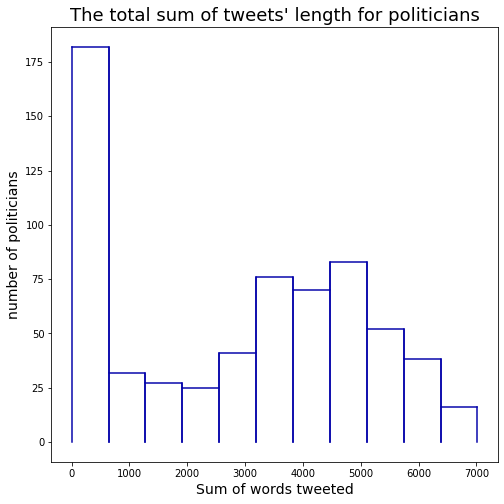

In [32]:
custom_histogram(pd.DataFrame(tweet_length_agg_dict.values()),"The total sum of tweets' length for politicians",'Sum of words tweeted','number of politicians')

Most of the politicians have tweeted in total between 0 and 500 words.
Then a "normal"-like distribution occurs with min around 2000 and max around 7000. There's a spike of around 5000 words tweeted.

Now plotting the distribution of the length of the tweets (again using Sturge's rule).

In [33]:
list2d=list(tweet_lengths_all_dict.values())
merged = list(itertools.chain(*list2d))

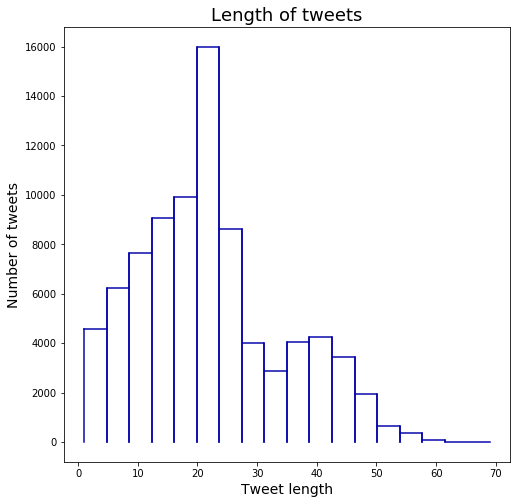

In [34]:
custom_histogram(pd.DataFrame(merged),'Length of tweets','Tweet length','Number of tweets')

In [35]:
max(merged)

69

Most of the tweets are around 20 words long and the distribution-tail flattens out with a maximum of 69 words. Twitter has a character limit of 280 where some emoticons might use more than one character. This means that the 69 words tweet has approx 4 characters per word on average if the limit has been met.

The API has a limit of 200 tweets, but not all politicians necessarily have tweeted 200 times. 
Plotting the distribution of the number of tweets collected.

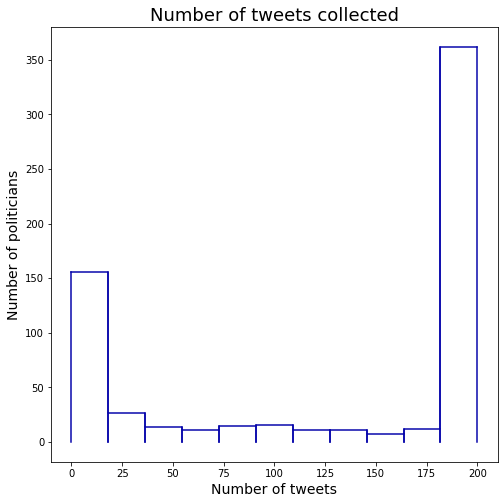

In [36]:
custom_histogram(pd.DataFrame(list(n_tweet_dict.values())),'Number of tweets collected','Number of tweets','Number of politicians')

In [37]:
# Lower quartile for number of tweets pr politician
math.floor((np.quantile(list(n_tweet_dict.values()),0.25)))

20

In [38]:
# Number of politicians with at least 200 tweets
a=np.array(list(n_tweet_dict.values()))
np.count_nonzero(a == 200)

312

25% of the politicians have 20 or less tweets and 312 politicians have 200 tweets. It is unfortunate that the Twitter API has this limit of 200 tweets, since it appears that much more data is just out of reach.

### Network statistics

The generation of the network is based on the previously generated dictionary from [Tweets (who mentions who)](#Tweets-(who-mentions-who)-(LAU)) section. 

When a politician e.g Lars Løkke, mentions another politician e.g. Morten Østergaard, the two politicians are connected. Each politician represents a node in the graph. When Lars Løkke mentions Morten Østergaard using the "@" symbol, a directed edge from Lars to Morten is added. Therefore, to incorporate the complexity of mentions on Twitter, a directed graph is chosen for the "Danish Politicians Twitter Network".

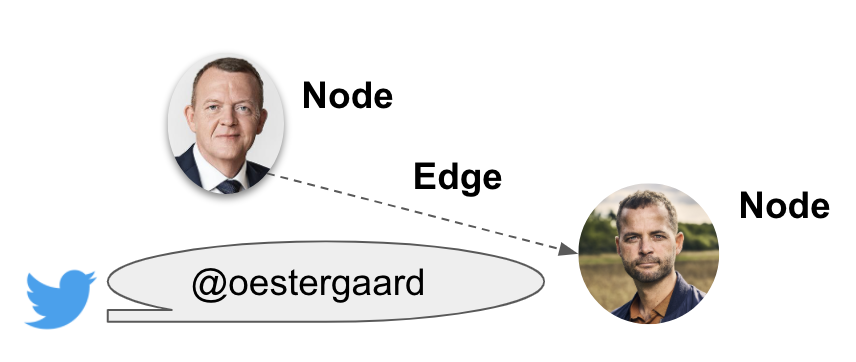

In [39]:
from IPython.display import Image
Image(filename='gif_house_of_cards/network.png')

For generating a graph representing the network of politicians on Twitter, the NetworkX library is used. The library makes it possible to create empty directed graphs, and one by one add connections (edges) between the politicians. The labels of the nodes are the politicians' usernames on Twitter.

When generating the network, it is assumed that if Lars Løkke mentions Morten Østergaard in e.g. 12 tweets, then the edge from Lars to Morten has a weight value of 12. If Lars then only mentions Margrethe Vestager 3 times, the edge from Lars to Vestager is 3. 

The weight $W_{ij}$ in the graph, therefore, represent the number of times politician (node) *i* mentions politician (node) *j*.

The weight for an edge is then calculated by finding the length of the list of tweets where politician *i* mentions politician *j*.

As a result, the profiles that are continuously popular will stand out even more from the rest, which might give a better understanding of the popularity of the profile.

In [40]:
G=nx.DiGraph()

for pol in list(tweet_dict.keys()): #All politician, i
    for to_pol in list(tweet_dict[pol].keys()): #All where i mentions, j
            if G.has_edge(pol, to_pol):
                # If there's already an edge, print an error
                print("error")
            else:
                G.add_edge(pol, to_pol, weight=len(tweet_dict[pol][to_pol]))

Save/load file locally:

In [41]:
#nx.write_gpickle(G, "second_network_w_weights_listversion_wrealnames_v2.gpickle")
G = nx.read_gpickle("second_network_w_weights_listversion_wrealnames_v2.gpickle")

Having created the graph, the first statistics of the network can be assesed.

In [42]:
print("The number of nodes: {}".format(G.number_of_nodes()))
print("The number of edges: {}".format(G.number_of_edges()))

The number of nodes: 561
The number of edges: 10445


Out of the 650 politicians, 561 of them has mentioned another politician or has been mentioned. Between all of the nodes, there are 10445 weighted edges.

To get the first glance of the network, networkx is used for plotting the graph. The size of the nodes is in this plot dependent on the degree.  

In [43]:
d = dict(G.degree(G.nodes()))

Networkx has a tool to give the weighted node degree. From [networkx.DiGraph.degree](https://networkx.org/documentation/stable/reference/classes/generated/networkx.DiGraph.degree.html): "The weighted node degree is the sum of the edge weights for edges incident to that node.". Thereby the degree of a node/Politician depends on the number of Tweets the politician has been mentioned in.

In [44]:
d_weight = dict(G.degree(G.nodes(),'weight'))

In [45]:
def get_change(current, previous):
    if current == previous:
        return 100.0
    try:
        return (abs(current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return 0

In [46]:
start=list(dict(G.degree(["vestager"])).values())[0]
print("The degree of Margrethe Vestager's node is ",start)

The degree of Margrethe Vestager's node is  48


In [47]:
end=list(dict(G.degree(["vestager"],'weight')).values())[0]
print('While the weight of the node is ',end)

While the weight of the node is  89


In [48]:
print('Thereby, the difference is a staggering',round(get_change(end,start),1),'% difference')

Thereby, the difference is a staggering 85.4 % difference


The use of weighted degree has a clear impact on the graph. Looking at Vestager again, the degree value increases by around 85%.

Vestager's node's in-degree difference between a non-weighted and a weighted is 85.4%.

The nodes where the distinction between degree and weight makes the biggest difference are shown below with the username and the percentage difference in degree vs weight.

In [49]:
deg_deff_dict={}
for node in list(G.nodes()):
    start=list(dict(G.degree([node])).values())[0]
    end=list(dict(G.degree([node],'weight')).values())[0]
    deg_deff_dict.update({node:get_change(end,start)})
    
sorted(deg_deff_dict.items(), key=lambda x: x[1], reverse=True)[0:5]

[('Forsvarsmin', 1150.0),
 ('HolmerHans', 1128.5714285714287),
 ('regeringDK', 933.6263736263737),
 ('MortenSkovlund', 833.3333333333334),
 ('LiselotteLyngeJ', 804.3478260869565)]

In [50]:
print("regeringDK degree: {}".format(G.degree("regeringDK")))
print("HolmerHans degree: {}".format(G.degree("HolmerHans")))

regeringDK degree: 455
HolmerHans degree: 7


In [51]:
print("regeringDK weight: {}".format(G.degree("regeringDK",'weight')))
print("HolmerHans weight: {}".format(G.degree("HolmerHans",'weight')))

regeringDK weight: 4703
HolmerHans weight: 86


The Danish Parliament has its own Twitter profile, which has a lot of mentions. With a degree of 455, it indicates that the profile is very connected. But including the weight, it is even more obvious that a lot of tweets from a lot of politicians mentions "regeringDK".

HolmerHans is Chairman of Social and Health at Kolding City Council. Using only the non-weighted degree, the importance of this Twitter profile could might be underestimated. When accounting for the number of tweets (weight) he suddenly becomes very active in the social Twitter network.

### Adding node attributes

We want to add some metadata to the Twitter network. Of course, this meta data will be the parties of these politicians, but since we can, also the regions that they belong to.

In [52]:
# defining a function that ensures G and dataframe are equal sizewise

def pre_check():
    nodes = G.nodes()
    count=0
    to_remove = [] 
    for node in nodes:
        if node in data.values:
            count+=1
        else:
            print(node + " will be removed")
            to_remove.append(node)
    for node in to_remove:
        G.remove_node(node)
    return len(to_remove)

print("Removing " +str(pre_check()) + " nodes")

Birgitte2012 will be removed
MFVMin will be removed
SassLarsen will be removed
AsgerChristens2 will be removed
Martin_geertsen will be removed
Removing 5 nodes


In [53]:
# Next we make a dict of attributes of "party" and "region" are these attributes

dict_of_attributes = {}
for node in G.nodes():
    #print(node)
    x = data.loc[data['Twittername'] == node]
    #print(x)
    party =  x.values[0][2]
    region = x.values[0][3]
    #print(node, party, region)
    attribute = {'party': party, 'region': region}
    dict_of_attributes[node] = attribute
nx.set_node_attributes(G, dict_of_attributes)

**Counting links between parties**

In [54]:
parties = list(nx.get_node_attributes(G,'party').values())
politicians=list(G.nodes)
unique_parties = set(parties)

tweet_to_count = {}
tweet_out_count = {}

for party in unique_parties:
    tweet_to_count[party] = 0
    tweet_out_count[party] = 0
    
# party in + out degrees
print("Edges (mentions): " + str(G.number_of_edges()))
for edge in G.edges():
    _from = edge[0]
    _to = edge[1]
    _to_party = parties[politicians.index(_to)]
    _out_party = parties[politicians.index(_from)]
    
    
    tweet_to_count[_to_party] += 1
    tweet_out_count[_out_party] += 1

    
tweet_to_count = dict(sorted(tweet_to_count.items(), key=lambda item: item[1], reverse=True))
tweet_out_count = dict(sorted(tweet_out_count.items(), key=lambda item: item[1],reverse=True))


Edges (mentions): 10263


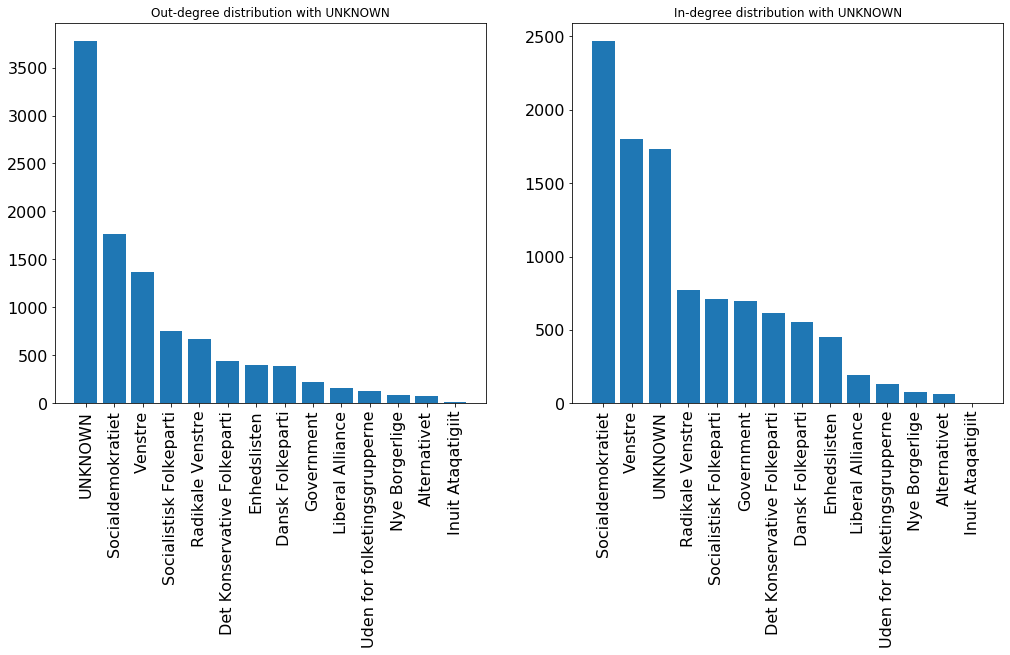

In [55]:
fig = plt.subplots(figsize=(17,7))
plt.subplot(1, 2, 1)
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_out_count.keys(), tweet_out_count.values())
plt.title("Out-degree distribution with UNKNOWN")

plt.subplot(1, 2, 2)
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_to_count.keys(), tweet_to_count.values())
plt.title("In-degree distribution with UNKNOWN")
plt.show()

**Without the unknowns** 


We want to see it without unknowns in the network and also the mean per person, as it's a bit skewed towards the parties that have the most politicians (more politicians = more tweets). First let's remove the unknowns:



In [56]:
# We remove the unknown key from the dict and saved the new dict as a copy
tweet_to_count_clean = tweet_to_count.copy()
tweet_out_count_clean = tweet_out_count.copy()

tweet_to_count_clean.pop('UNKNOWN')
tweet_out_count_clean.pop('UNKNOWN')


3778

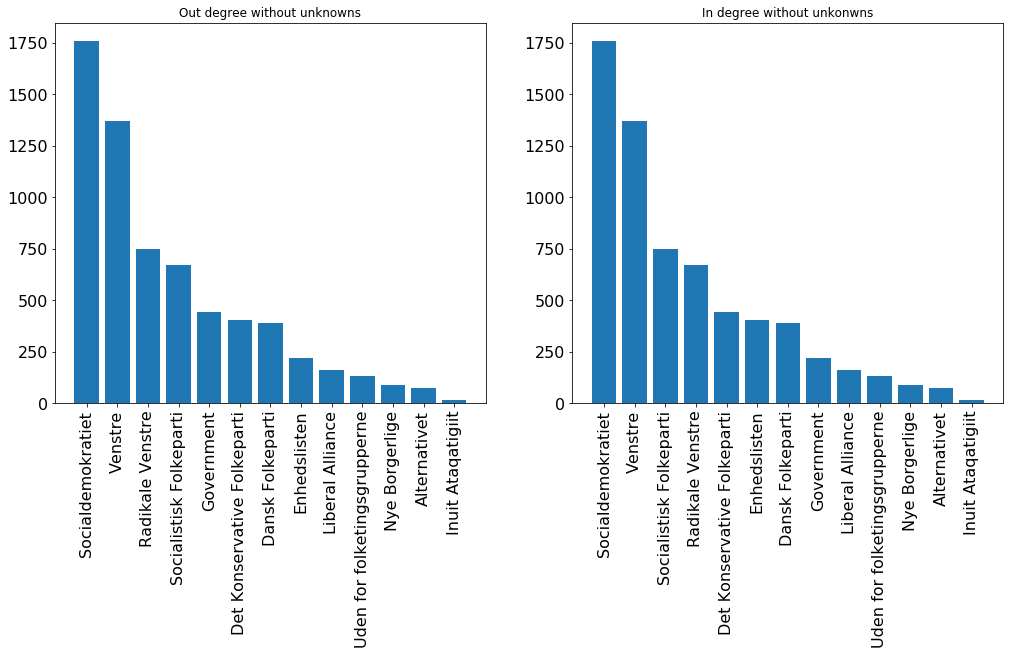

In [57]:
fig = plt.subplots(figsize=(17,7))

plt.subplot(1,2,1)
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_to_count_clean.keys(), tweet_out_count_clean.values())
plt.title("Out degree without unknowns")

plt.subplot(1,2,2)
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_out_count_clean.keys(), tweet_out_count_clean.values())
plt.title("In degree without unkonwns")
plt.show()


It is still quite clear that those who have the most politicians would have the highest amount of mentions and tweets. Therefore we are interested in normalizing this distribution, so let's get the mean instead.



In [58]:
vals = nx.get_node_attributes(G, "party").values()
sum_party =dict.fromkeys(tweet_out_count.keys(),0)
for party_occ in vals:
    sum_party[party_occ] += 1
sum_party

avg_tweet_out = dict.fromkeys(tweet_out_count.keys())
avg_tweet_in= dict.fromkeys(tweet_to_count.keys())

for key in tweet_out_count:
    avg_tweet_out[key] = tweet_out_count[key] / sum_party[key]
    avg_tweet_in[key] = tweet_to_count[key] / sum_party[key]
    
ang_tweet_out = dict(sorted(avg_tweet_out.items(), key=lambda item: item[1],reverse=True))
avg_tweet_in = dict(sorted(avg_tweet_in.items(), key=lambda item: item[1],reverse=True))


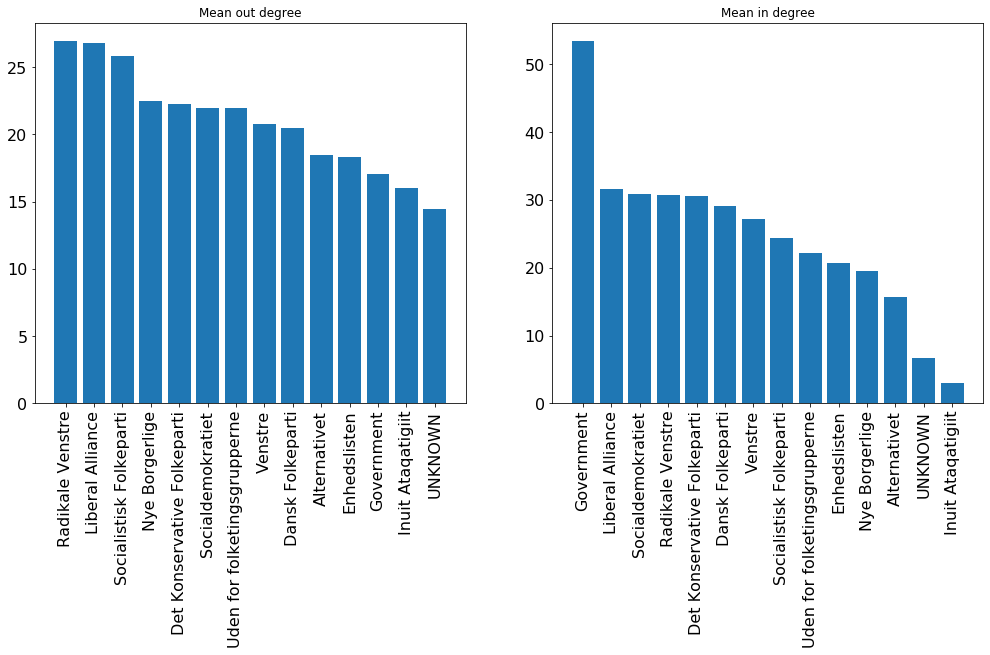

In [59]:
fig = plt.subplots(figsize=(17,7))
plt.subplot(1,2,1)
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(ang_tweet_out.keys(), ang_tweet_out.values())
plt.title("Mean out degree")

plt.subplot(1,2,2)
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(avg_tweet_in.keys(), avg_tweet_in.values())
plt.title("Mean in degree")
plt.show()

Now we see a clear difference, it is no longer Venstre and Sodicaldemokratiet dominating the mentions. Instead, as expected the government has the most people tweeting to it, and Radikale Venstre, Liberal Alliance, and Socialistisk Folkeparti, do pull ahead in the number of times they mention other parties on average.

Let's try to visualize the network now with the party colors as node colors. The colors are as close to the ones they state is their signature color when it could be found, then we marked all unknowns as white in the below graph

In [60]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=color_map, alpha=0.7,node_size=[v * 1 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)

plt.axis('off')
plt.show()

NameError: name 'giant' is not defined

**Observations**

The graph is quite compact, with many large blues and red nodes which makes sense, as these are the biggest parties in Denmark; namely "Venstre" and "Socialdemokratiet". Furthermore, there are large black nodes that are central in the network - this also makes sense as we've marked government entities as black. However, there are still some problems with the visualization that we want to solve.


**Segregating into red and blue blocs**

The problem with the network visualization is that we have too many different parties and getting a nice visualization becomes difficult. Bloc politics refers to the act of parties uniting in order to gain a majority vote over the parliament. In danish politics, according to https://da.wikipedia.org/wiki/Blokpolitik we have 3 blocs, red blue, and green. We will segregate our parties into this by adding a graph attribute "bloc". Furthermore, we will eliminate the unknowns to get a graph that's more manageable.

In [ ]:
red_bloc = ['Socialdemokratiet', 'Enhedslisten', 'Socialistisk Folkeparti', 'Radikale Venstre']
blue_bloc = ['Venstre', 'Dansk Folkeparti', 'Det Konservative Folkeparti', 'Liberal Alliance', 'Nye Borgerlige', 'Fremad']
green_bloc = ['Alternativet']
    
    
for key, val in dict_of_attributes.items():
    #print(key)
    if val['party'] in red_bloc:
        val['block'] = 'red'
    elif val['party'] in blue_bloc:
        val['block'] = 'blue'
    elif val['party'] in green_bloc:
        val['block'] = 'green'
    elif val['party'] == 'Government':
        val['block'] = 'black'
    else: 
        val['block'] = 'white' # white node means unknown
        
nx.set_node_attributes(G, dict_of_attributes)

Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)

giant = G.subgraph(Gcc[0])
giant = giant.to_undirected()
d = dict(giant.degree) #degrees for every node

for node in list(giant.nodes()):
    if (giant.degree(node) <= 2):
        giant.remove_node(node)

# removing the unknowns
for node in list(giant.nodes(data=True)):
    if (node[1]['block'] == 'white'):
        giant.remove_node(node[0])
        
bloc_color_map = list(nx.get_node_attributes(giant, 'block').values())
d = dict(giant.degree) #degrees for every node

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=bloc_color_map, alpha=0.7,node_size=[v * 3 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

G = nx.read_gpickle("second_network_w_weights_listversion_wrealnames_v2.gpickle")

The network looks a bit neater, but we can observe that the large central government profiles have decreased in degree, signaling that a lot of the unknowns have tweeted to that profile. Interestingly, the visualization algorithm is is general putting the few green politicians closer to the red ones.


**Conclusion:**

With 561 danish politicians, connected by 10445 edges a directed graph representing a "Social network of Danish politicians on Twitter" has been created. The graph is directed do to the distinction between politician A mentioning politician B, and the other way around. Using a weighted directed graph emphasizes the importance of the number of tweets on Twitter. 

# Tools, theory and analysis

## Overall idea

By translating twitter relationships and mentions into a network, it is possible to shed light on how politicians are connected. Some politicians may be more connected than others, and with the use of network theory, it is possible to divide the policies into groups so that those who are most connected belong to the same group.

This connection can provide new insights into how politicians can perhaps more effectively gather and discuss relevant political issues with other politicians talking about the same thing. At the same time, politics is also a game - so it is interesting to use the network to find out how politicians can influence each other by knowing who is connected to whom.

Today, politics is divided into parties. It will be interesting to see if the way the parties currently cooperate reflects the way the parties talk about each other on Twitter. This analysis assumes that if party members are mentioned in positively loaded tweets, then these have a more positive connection to the person who tweeted. (and vice versa with the negative). Does Twitter, therefore, reflect the world inside the Parliament concerning how parties are affiliated?

Finally, text analysis is carried out at the meetings of the Parliament. Word clouds must provide insight into what topics the politicians are talking about in the Parliament. This is divided into two levels: community level and party level. Do politicians talk about the same thing at the Parliament as they do on Twitter? Can we see any similarities? Does twitter reflect the actual political system? ARE the topics on Twitter the same topics that are talked about at the Parliament?



The analysis is structured in the following way.

[Analysis step 1: Network](#Analysis-step-1:-Network)
* Does the network represent a social graph?
* The property of the networks. What characterizes the "Danish Politicians Twitter Network"?
* HOUSE OF CARDS: "How are politicians connected?" "Who should one talk to, to influence a specific politician?"

[Analysis step 2: Community detection and wordclouds](#Analysis-step-2:-Community-detection-and-wordclouds)
* Can new communities in the political system be identified? Using network theory the goal is to find new communities that represent how the politicians are connected on Twitter.
* What do the communities tweet about? By getting insight into what the communities are tweeting about, there can might be some indication of how politicians should group up and discuss. Politicians tweeting about the same topics could maybe benefit from meet each other and discuss the same topics. This could potentially give a more efficient political system. 

[Analysis step 3: Parties and Sentiment](#Analysis-step-3:-Parties-and-Sentiment)
* Are the sentiments of the tweets negative or positive loaded? The tone of the tweets that the public reads can influence how people think about a topic or another politician. 
* Which parties talk positively about each other? Which parties talk negatively about each other? The tone of the tweets in which politicians mention others will give a potential idea of how the parties are connected. The parties cooperate across alliances at the parliament - but is this represented in the same way on Twitter?


[Analysis step 4: Parliament+twitter topics](#Analysis-step-4:-Parliament+twitter-topics)
* What do the newly found communities talk about at the Parliament? By making text analysis on the Parliament meeting it is assessed whether the tweets' topics represent the same topics which also are discussed in the Parliament.
* Do the parties tweet about the same topics as they talk about at the parliament? These questions examine whether Twitter represents the topics of the parties as they are expressed in the Parliament.

## Analysis step 1: Network

This project aims to build models that reproduce the properties of real networks. To examine whether the graph reproduces a real network or it is just a random network, the degree distribution of a random network is compared to the Twitter network. 

By examining the properties of the "Danish Politicians Twitter Network", there can be shed light on how politicians can influence each other. This project assumes, that a politician is interested to know how to influence others most effectively and how to spread a message to the public including the other politicians. 

Next, the in- and out-degree of the graph is assesed. This is done in order to get an idea of how the politicians are connected.

In [ ]:
list_in=list(dict(G.in_degree()).values()) # This is all of the nodes' in-degrees
list_out=list(dict(G.out_degree()).values()) # This is all of the nodes' out-degrees

In [ ]:
custom_histogram(list_in,"Binning in-degree distribution","in-degree","Frequency")
custom_histogram(list_out,"Binning out-degree distribution","out-degree","Frequency")

From [Network Sciencebook - Chapter 3, sec. 3.2](http://networksciencebook.com/chapter/3):
"A random network consists of N nodes where each node pair is connected with probability p."

To calculate the probability p of the Twitter Network of politicians, the average degree, k, is found. From [Network Sciencebook - Chapter 3, sec. 3.3](http://networksciencebook.com/chapter/3#random-network) eq. 3.3 the following holds:

$k = p ( N-1)$

so $p = \frac{k}{N-1}$

Since *k* is equal to the average degree, networkx can be used to calculate the value.

In [ ]:
k=np.mean(list(dict(G.degree()).values())) 
print(round(k,2))

Initially, it seems rather high to be connected to 37 people on average, however, by looking at the degrees of the most connected nodes, it can be seen few accounts are highly connected while others have only degree 0, i.e. they do not mention anyone and are not mentioned.

In [ ]:
sorted(G.degree(), key=lambda x: x[1], reverse=True)[0:5]

In [ ]:
sorted(G.degree(), key=lambda x: x[1], reverse=True)[-5:]

The number of nodes:

In [ ]:
N=G.number_of_nodes()

The probability of each pair of nodes is connected:

In [ ]:
p=k/(N-1)
print(round(p,5))

Generating the random graph (erdos_renyi, ER) from extracted parameters

In [ ]:
G_ER=nx.erdos_renyi_graph(N,p,directed=True) 

Plotting the degree distribution for the ER graph.

In [ ]:
list_in_r=list(dict(G_ER.in_degree()).values())
list_out_r=list(dict(G_ER.out_degree()).values())

In [ ]:
custom_histogram(list_in_r,"Binning in-degree distribution for random graph","in-degree","Frequency")
custom_histogram(list_out_r,"Binning out-degree distribution for random graph","out-degree","Frequency")

**Conclusion:**

Comparing the distribution of the Twitter network and a random graph, it can be concluded, that there is indeed a difference in the degree distribution. 

The Twitter network's in-degree distribution is more right-skewed than the random network. 
Even though the Twitter network's out-degree has a more normal-like distribution structure, there's still a big spike at out-degree between 0 and 5.  

### Using the giant connected component (GCC)

The generated network should be representing the Danish politicians' Twitter network - therefore, it should not be "just" a random graph. 

The main difference between a random graph and a scale-free network is the so-called *hubs*. According to [Network Science Book - section 5.2](http://networksciencebook.com/chapter/5) new nodes in most real networks prefers to link to the more connected node. This process is "preferential attachment". Preferential attachment and growth, are the two properties of the emerging of a scale-free network. Scale-free networks are networks, which degree distribution is different from the degree distribution of a random network.

The probability of two nodes linking influences the structure of the graph. There are two extreme cases. If p=0, there's zero probability that any node links to another - all nodes are isolated. If p=1, there's 100% probability that any node links to another - the graph is complete, i.e. all nodes links to each other. To get insight into how the politician Twitter network structures itself, the following analysis will examine the link-probability and number of nodes. Once the average node degree exceeds a critical value, the rapid emergence of a large cluster that we call the giant connected component occurs. 

There are four different topological distinct regimes according to [Network Science Book - section 3.6](http://networksciencebook.com/chapter/3#evolution-network). One can distinguish between them by looking at their characteristics - more specifically on the relation between p and N. 

In [ ]:
print(p >math.log(N)/N)

The regime is a connected regime because of p>ln(N)/N. This indicates that the Twitter network will emerge to a GCC, which absorbs all nodes and components. 

According to [Network Science Book - section 3.7](http://networksciencebook.com/chapter/3#networks-supercritical) most networks are supercritical. But e.g. the real network of Actors is in the connected regime. The properties of the politician Twitter network are therefore consistent with some of the properties of other real world networks. 

The critical point separates the regime where there's is a GCC from the one where there's not.
For the network to be at a critical point k, the average node degree must be equal to 1. This also means that pc=1/N.

In [ ]:
pc=1/(N-1) 
print("{:.4f}".format(pc))

The linking probability for the Twitter network must be 2% for the network to be at the critical point. If the probability is 2% or lower, all of the politicians are connected in small components. In the aspect of the influence of politics, the Twitter network will then become much more "useless" for a politician if the linking probability was lower. To further analyze the GCC of the Twitter network, the GCC can be extracted using networkx.

The algorithm for finding the GCC (and also later using forceatlas to make nice visualizations) needs the graph to be undirected.

In [ ]:
G_undirected=G.to_undirected()

Extracting the GCC:

In [ ]:
Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)
giant_directed=G.subgraph(Gcc[0])
giant = G_undirected.subgraph(Gcc[0])
d = dict(giant.degree) #Saves the degree for making the nodesize depended of the degreee in plots

In [ ]:
print("The number of nodes: {}".format(giant_directed.number_of_nodes()))
print("The number of edges: {}".format(giant_directed.number_of_edges()))

The GCC contained 549 politicians out of 561. This shows how almost all politicians are absorbed in the GCC. Below is a visualization of the component.

In [ ]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

In [ ]:
plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, alpha=0.4,node_size=[v * 1 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

According to [Network Science Book - section 4.2](http://networksciencebook.com/chapter/4) the degrees of a random network follows a poisson distribution. Therefore, a random network is generated, and the distribution of the degrees can be compared on a normal scale and log-log scale.

Generating the random graph by initially finding N and p for the graph:

In [ ]:
k_giant=np.mean(list(dict(giant.degree()).values())) 
print('k =',round(k_giant,1))

# The number of nodes:
N_giant=giant.number_of_nodes()
print('N =',round(N_giant,1))

# The probability of each pair of nodes is connected:
p_giant=k_giant/(N_giant-1)
print('p =',round(p_giant,5))

# Generating the random graph from extracted parameters.
G_r = nx.generators.fast_gnp_random_graph(N_giant,p_giant)

degree_freq_r = nx.degree_histogram(G_r)
degrees_r = range(len(degree_freq_r))

Plotting the random graph degree distribution and the GCC graphs degree.

In [ ]:
fig, axs = plt.subplots(2,figsize=(13,10))
fig.suptitle('Degree distribution of network',size=25)
m=1

degree_freq = nx.degree_histogram(giant)
degrees = range(len(degree_freq))

#####PLOT 1##########
axs[0].plot(degrees[m:], degree_freq[m:],'go')
axs[0].plot(degrees_r[m:], degree_freq_r[m:],'bo-')
green1_patch = mpatches.Patch(color='g', label='Degrees of GCC')
blue1_patch = mpatches.Patch(color='b', label='Degrees of random network')
axs[0].legend(handles=[blue1_patch,green1_patch])


###PLOT 2 ######
axs[1].loglog(degrees[m:], degree_freq[m:],'go')
axs[1].loglog(degrees_r[m:], degree_freq_r[m:],'bo-')
green2_patch = mpatches.Patch(color='g', label='Degrees of GCC')
axs[1].legend(handles=[green2_patch])
blue2_patch = mpatches.Patch(color='b', label='Degrees of random network')
axs[1].legend(handles=[blue2_patch,green2_patch])



axs[0].set_ylabel('Number of nodes',fontsize = 14)
axs[1].set_xlabel('k',fontsize = 14)
axs[1].set_ylabel('Number of nodes',fontsize = 14)

plt.subplots_adjust(hspace=0.1)

**Conclusion:**
To yet examine the randomness, the above plots can be inspected. On the log-log plot, the degree distribution of the GCC, the power-law follows an approximately straight line. The GCC of the Twitter network is therefore different from the poisson distribution (random network). Since the Twitter network follows the power-law, it is therefore according to [Network Science Book - section 4.2](http://networksciencebook.com/chapter/4) a **scale-free network**. 


A property of a scale-free network is the nature of preferential attachment. This affects the degree of the largest node, so new politicians joining Danish politics (and Twitter) will prefer to connect to some of the hubs in the network. One or a few large hubs connects to most of the notes, which can represent some of the most influential Twitter profiles. Or, at least be a great potential source of bringing a message. The graph is in the connected regime, and the GCC of the Twitter network absorbs all nodes. Therefore, all politicians are somehow connected in the Twitter network - the next question is then: "How are they connected?" "Who should a politician address in order to cement a political agenda?"


### HOUSE OF CARDS - The Danish version

"Who should a politician address in order to cement a political agenda?" This question reminds one of the plots from [House of Cards](https://en.wikipedia.org/wiki/House_of_Cards_(American_TV_series)):


"*Congressman Frank Underwood (Kevin Spacey), a Democrat from South Carolina's 5th congressional district and House Majority Whip, and his equally ambitious wife Claire Underwood (Robin Wright). Frank is passed over for appointment as Secretary of State, so he initiates an elaborate plan to attain power, aided by Claire. The series deals with themes of ruthless pragmatism, manipulation, betrayal, and power.*"

This story is possibly more dramatized than the real life of Danish politicians. Nevertheless, this case is called "House of Cards - the Danish version". If a few politicians on Twitter connect to many others, then these could potentially have a great influence on the formation of public opinion - and maybe also the opinion of other politicians.

If a politician should indirectly address a person through Twitter, by talking to a person who knows a person who knows a person..., it is interesting to know what the greatest distance in the network is. This is the same as the diameter of the graph. 

In [ ]:
nx.diameter(giant)

Between any two politicians, the maximum number of people connecting the two is 6. This number is actually quite interesting because [Network Science Book - section 3.8](http://networksciencebook.com/chapter/3#small-worlds) describes the "Small World Phenomenon": that two individuals anywhere on Earth, you will find a path of at most six acquaintances between them. The Twitter network giant has only 549 nodes, so the distance between any two nodes should probably be less than 6. [Network Science Book - section 3.8](http://networksciencebook.com/chapter/3#small-worlds)  states that:

< k > nodes should be at distance one

$< k >^{2}$ nodes should be at distance two

$< k >^{3}$ nodes should be at distance three...

where < k > is the average degree.

In [ ]:
print("<k>: {}".format(round(k_giant,1)))
print("<k>^2: {}".format(round(math.pow(k_giant,2),1)))

This means, that almost all politicians should be in a distance of 2 from eachtoher. The average shortest path can shed more light on this:

In [ ]:
round(nx.average_shortest_path_length(giant),2)
#nx.average_shortest_path_length(giant_directed)

As expected, the average shortest path between two politicians in the Twitter network is approx. 2. 

The average shortest path of the Twitter network confirms, that the small-world phenomenon holds for the Danish Twitter Network. The following demonstration shows how a random politician is (almost) 2 nodes away from all others.

Also, this is based on who mentions each other on Twitter so actually, the result is rather cool.

This code can generate a plot for finding and visualizing nodes that are *d* nodes away from a node:

In [ ]:
def plot_d_step_away(node_name,graph,d,color_for_nodes,plotting="yes"):
    #Saves the shortest path
    values=np.array(list(nx.single_source_shortest_path_length(giant,node_name).values()))
    nodess=np.array(list(nx.single_source_shortest_path_length(giant,node_name).keys())) 
    
    #Making a bool-list which detects if the path (or steps) are equal to d:
    steps2= [True if element==d else False for element in values]
    
    #The bool-list can then select the nodes which are d steps away:
    
    nodes2=nodess[steps2]
    
    dic=nx.single_source_shortest_path_length(giant,node_name)
    
    
    
    color_map = []
    alpha_list=[]
    for node in giant:
        if node == node_name:
            color_map.append('green')
            alpha_list.append(1)
        elif node in nodes2:
            color_map.append(color_for_nodes)
            #alpha_list.append(dic[node]*0.5)
            alpha_list.append(1)
        else: 
            color_map.append('grey')  
            alpha_list.append(dic[node]*0.2)
            
    if plotting=="yes":
        plt.figure(figsize=(10,20))
        nx.draw_kamada_kawai(giant,node_size=50, node_color=color_map)
        plt.title("GCC (Green random node with "+color_for_nodes +"coloured nodes "+str(d)+" steps away",fontsize=18)
        plt.show()
    
    return color_map,alpha_list


Choosing a random politician:

In [ ]:
#rc=random.choice(list(giant.nodes()))
rc="StemClausson"  #only random the first time for reproducability
print(rc)

Create forceatlas positions for the giant connected component to enamble the subsequent plot with different colors.

Finding the nodes that are 1, 2, 3, 4, 5, and 6 nodes away :

In [ ]:
c_map,alpha_list=plot_d_step_away(rc,giant,1,"red",plotting="no")
c_map2,alpha_list2=plot_d_step_away(rc,giant,2,"blue",plotting="no")
c_map3,alpha_list3=plot_d_step_away(rc,giant,3,"purple",plotting="no")
c_map4,alpha_list4=plot_d_step_away(rc,giant,4,"orange",plotting="no")
c_map5,alpha_list5=plot_d_step_away(rc,giant,5,"magenta",plotting="no")
c_map6,alpha_list6=plot_d_step_away(rc,giant,6,"cyan",plotting="no")

#Saves all list together:
c_map_all=[c_map,c_map2,c_map3,c_map4,c_map5,c_map6]
alpha_list_all=[alpha_list,alpha_list2,alpha_list3,alpha_list4,alpha_list5,alpha_list6]

Make StemClaussons node bigger than the others.

In [ ]:
n_sizes = [50 if node!='StemClausson' else 450 for node in list(giant.nodes())   ]

To make a nice GIF for the website, the nodes that are 1-4 steps away from StemClausson is generated (no are more than 4). Then they are uploaded to https://ezgif.com/maker, which genrates the GIF.

In [ ]:
for i in range(4):
    plt.figure(figsize=(20,10))
    
    #Draw the graph
    nx.draw_networkx_nodes(giant, positions,node_color=c_map_all[i],node_size=n_sizes)
    nx.draw_networkx_edges(giant, positions, edge_color="grey", alpha=0.1)

    #Legends
    patch1 = Line2D([0], [0], marker='o', color='w', label='1 step away',
                        markerfacecolor='r',markersize=20)
    patch2 = Line2D([0], [0], marker='o', color='w', label='2 step away',
                        markerfacecolor='b',markersize=20)
    patch3 = Line2D([0], [0], marker='o', color='w', label='3 step away',
                        markerfacecolor='purple',markersize=20)
    patch4 = Line2D([0], [0], marker='o', color='w', label='4 step away',
                        markerfacecolor='orange',markersize=20)
    patch5 = Line2D([0], [0], marker='o', color='w', label='StemClausson',
                        markerfacecolor='green',markersize=20)
    plt.legend(handles=[patch5,patch1,patch2,patch3,patch4],loc=2,prop={'size': 20},bbox_to_anchor=(0, 0),ncol=5)
    plt.axis('off')
    plt.savefig('gif_house_of_cards/gif_pic_'+str(i)+'.png')
    plt.show()
    
    

Plot colors for all nodes that are *d* distance away.

In [ ]:
def plot_d_step_away_all(node_name,graph,plotting="yes"):
    #Saves the shortest path
    
    dic=nx.single_source_shortest_path_length(giant,node_name)
    
    mx=max(dic, key=dic.get)
    mx=dic[mx]
    
    color_list=["red","blue","purple","orange","pink","brown"] #diameter is 6, so only 6 colors
      
    
    color_map = []
    alpha_list=[]
    for node in list(graph.nodes()):
        if node == rc:
            color_map.append('green')
            alpha_list.append(0.3)
        else:
            color_map.append(color_list[dic[node]-1]) 
            alpha_list.append(dic[node]*0.2)
            
    if plotting=="yes":
        plt.figure(figsize=(10,20))
        nx.draw_kamada_kawai(giant,node_size=50, node_color=color_map)
        plt.title("GCC (Green random node with coloured nodes d steps away",fontsize=18)
        patch1 = mpatches.Patch(color='r', label='1 step away')
        patch2 = mpatches.Patch(color='b', label='2 step away')
        patch3 = mpatches.Patch(color='purple', label='3 step away')
        patch4 = mpatches.Patch(color='orange', label='4 step away')
        patch5 = mpatches.Patch(color='pink', label='5 step away')
        patch6 = mpatches.Patch(color='brown', label='6 step away')
        
        plt.legend(handles=[patch1,patch2,patch3,patch4,patch5,patch6])
        
        plt.show()
    
    return color_map, alpha_list

In [ ]:
c_map_all,alpha_list=plot_d_step_away_all(rc,giant,plotting="no")

In [ ]:
plt.figure(figsize=(20,10))
#nx.draw_networkx_nodes(giant, positions, alpha=alpha_list,node_size=[v * 1 for v in d.values()],node_color=c_map_all)

nx.draw_networkx_nodes(giant, positions, alpha=alpha_list,node_color=c_map_all,node_size=50)
nx.draw_networkx_edges(giant, positions, edge_color="grey", alpha=0.05)
patch1 = mpatches.Patch(color='r', label='1 step away')
patch2 = mpatches.Patch(color='b', label='2 step away')
patch3 = mpatches.Patch(color='purple', label='3 step away')
patch4 = mpatches.Patch(color='orange', label='4 step away')
patch5 = mpatches.Patch(color='pink', label='5 step away')
patch6 = mpatches.Patch(color='brown', label='6 step away')

plt.legend(handles=[patch1,patch2,patch3,patch4,patch5,patch6])
plt.axis('off')
plt.show()

The visualization above shows how the Danish politician, StemClausson (green node on the left side of the graph), is connected with all the other politicians. Most of the nodes are blue, which means that most of the nodes are two steps away. 

Lets say, that a random politician wants to influence one of the most central, according to degree centrality:

In [ ]:
sorted(giant_directed.degree(), key=lambda x: x[1], reverse=True)[0:5]

Let's take "larsloekke", then the random politician's shortest path for influence "larsloekke". Here, it is assumed, that if "larsloekke" mentions politician A, then politician A can influence "larsloekke" or at least "larsloekke" explicit "interacts" with person A. 

In [ ]:
print(nx.shortest_path(giant_directed, source="larsloekke", target=rc))
print("length: " +str(len(nx.shortest_path(giant_directed, source="larsloekke", target=rc))))

From the random person, StemClausson, to larsleokke, there are 3 persons between. StemClausson should then talk with mariannefrede20, in order to try to influence larsloekke.

Another advantage of having the network is, that if StemClausson can NOT directly talk to larsloekke, then he can might talk to some of larsloekke's inner circle. For this purpose, a politician should find the neighbors of larsloekke: 

In [ ]:
[n for n in giant_directed.neighbors('larsloekke')]

StemClausson can then contact one of the above persons, and hope they can influence larsloekke.

What if StemClausson want to influence a random politician? Lets draw a random.

In [ ]:
#rc2=random.choice(list(giant.nodes()))
rc2 = "RasmusNorupC" #only random the first time for reproducability
print("The random politician is: " +rc2)

The random politician is RasmusNorupC. How are StemClausson and RasmusNorupC connected? Who should StemClausson talk to in order to indirectly make an infulence on RasmusNorupC?

In [ ]:
sp=nx.shortest_path(giant_directed, source=rc2, target=rc)
print(sp)
print("length: " +str(len(sp)))

In [ ]:
sp.reverse() #Reverse the list

In [ ]:
print("From "+rc +" to "+rc2 +"the following persons should talk with eachother \n"+'\ntalks to...'.join(sp))

## Analysis step 2: Community detection and wordclouds

### Identify the communities

To identify communities in the Twitter network, the best_partition algorithm is used, which seeks to maximize the modularity of each community using Louvain heuristics.

The highest modularity is found by the highest partition of the dendrogram generated by the Louvain algorithm.

The definition of modularity is defined in [Network Science Book - section 9.4](http://networksciencebook.com/chapter/9#modularity) equation 9.12.


$M=\sum_{c=1}^{n_c} [\frac{L_c}{L}-(\frac{k_c}{2L})^2]$

where $L_c$ is the total number of links within the community $C_c$ and $k_c$ is the total degree of the nodes in this community.

$n_c$ is the number of communities.

Creating the partitions:

In [ ]:
##### Loading the partitions
with open('communities.data', 'rb') as filehandle:
    # store the data as binary data stream
    partition_GCC=pickle.load(filehandle)

In [ ]:
print(len(set(partition_GCC.values())),' communities is found in total.')

The GCC has been divided into 16 communities. Here's a distribution of the community-sizes.

In [ ]:
a=np.array(list(partition_GCC.values()))
b = Counter(a)

#Extracting the number of nodes in each commnuity
community_sizes=[i[1] for i in b.most_common(len(set(partition_GCC.values())))]

custom_histogram(community_sizes,"Distribution of community sizes","community size","frequency")

The most of the communities contains between 33 and 48 politicians. 

In [ ]:
##### SAVING THE COMMUNITIES TO A FILE
#with open('communities.data', 'wb') as filehandle:
    # store the data as binary data stream
#    pickle.dump(partition_GCC, filehandle)

### Concatenating all tweets for each politician

For making word clouds that could give insight into which topics the politicians in the communities tweets about, processing of the real text. A TF-IDF transformation of the word is made, then the word cloud shows the words that characterize the communities. 

Before doing the TF-IDF transformation, all the tweets for each politician is concatenated.

In [ ]:
with open('tweet_concat_v2.data', 'rb') as filehandle:
    dict_concat = pickle.load(filehandle)     

Before building the TF list, both English and Danish stopwords are removed.

In [ ]:
stopwords_danish = stopwords.words('danish')
Danish_stopwords = open('stopord.txt').read().splitlines() #Link: https://gist.github.com/berteltorp/0cf8a0c7afea7f25ed754f24cfc2467b

stopwords_edit=STOPWORDS #English stopwords
stopwords_edit=stopwords_edit.union(Danish_stopwords)
stopwords_edit=stopwords_edit.union(stopwords_danish)
stopwords_edit=stopwords_edit.union(['rt','se','få','komme','dkpol','lige','kan','så','ved',
                           'hvert','bruge','både','måde'])# RT is some twitter syntax 

#More danish verbs are available at: http://fjern-uv.dk/250.pdf

In [ ]:
largest_communities=list(set(partition_GCC.values()))

In [ ]:
community_text =  dict()
TF = dict()

for i in largest_communities:

    common_characters = [k for k,v in list(partition_GCC.items()) if v == largest_communities[i]]

    # reset collection of words for each community
    words=[]

    # Tokenize the text in all files in community i and concatenate into one text
    for pol in list(dict_concat.keys()):
            if pol in common_characters:
              
                words += nltk.word_tokenize(dict_concat[pol])
    
    # enter all text from community i in a dict
    tokens = [word.lower() for word in words if (word.isalnum() and word.lower() not in stopwords_edit)]
    
    community_text[largest_communities[i]] = tokens

for i in community_text.keys():
    TF[i] = FreqDist(community_text[i])

In [ ]:
# number of words and text
common_communities=largest_communities
for i in range(len(common_communities)):
    print('Community ', common_communities[i],' has ', len(community_text[common_communities[i]]), ' words')

The number of words vary a lot, but overall, it seems as if there is enough material to proceed with analyses.

**IDF (The following text is also in assignment 2)**

To calculate the TF-IDF we multiply TF and IDF with each other. TF is the raw count of any word in each community and IDF is the *Inverse Document Frequency Smooth*: $log\frac{N}{n_t+1}+1$,
where $N$ is the total number of communities and $n_t$ is the total number of communities which contains the term $t$.


The motivation behind using this formula is that it gives a high score for a word that is frequent in a few communities and a low score for words that are frequent in many communities. This way, the result indicates words that are especially significant to the individual communities and hence relevant in a word cloud.


We use the raw count (TF weighting scheme) because we expect the speech in the communities to be rather similar, as we expect the politicians to comment on similar topics mentioning the same people.
Furthermore, stopwords are excluded. If these were included it might have been preferable to use another measure for TF.



In [ ]:
#inverse document frequency
def IDF_for_word(word, this_com_name, TF_other_community, N):
 
    nt=0
 
    for com in list(TF_other_community.keys()):
        if word in TF_other_community[com] and com != this_com_name:
            nt = nt+1
 
    w_IDF=np.log(N/(nt+1))+1
    return w_IDF

In [ ]:
IDF = dict()

for community in TF.keys():
    IDF.update({community: {}})
    for word in TF[community].keys():
        IDF[community].update({word: IDF_for_word(word, community, TF, len(common_communities))})
        
        
TF_IDF = dict()

for community in TF.keys():
    TF_IDF.update({community: {}})
    for word in TF[community].keys():
        TF_IDF[community].update({word: TF[community][word]*IDF[community][word]})

In [ ]:
twitter_mask=np.array(Image.open('twitter_sil.jpg'))

In [ ]:
for community in TF_IDF.keys():
    community_WordCloudText = ' '.join([word for word in list(TF_IDF[community].keys()) for i in range(math.ceil(TF_IDF[community][word]))])

    plt.figure(figsize=(10,20))
    community_wordcloud = WordCloud(collocations=False, mask=twitter_mask, background_color='white', stopwords=stopwords_edit).generate(community_WordCloudText)
    plt.imshow(community_wordcloud, interpolation='bilinear')
    plt.savefig('com_wordclouds/community'+str(community)+'.png')
    plt.title(label=('Community '+str(community)))
    plt.axis("off")

Extracting the 8 largest communities and naming them after the three most prominent politicians in the community to have an appropiate amount of politicians in each community.

In [ ]:
largest_8_communities=[i for i in b.most_common(8)]

In [ ]:
G_com_6=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]==6 ])
G_com_3=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]== 3])
G_com_0=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]==0 ])
G_com_4=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]==4 ])
G_com_12=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]==12 ])
G_com_8=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]==8])
G_com_9=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]==9 ])
G_com_1=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]==1 ])

In [ ]:
print("Community 6 is named: "+' & '.join([x[0] for x in sorted(G_com_6.degree, key=lambda x: x[1], reverse=True)[:3]]))
print("Community 3 is named: "+' & '.join([x[0] for x in sorted(G_com_3.degree, key=lambda x: x[1], reverse=True)[:3]]))
print("Community 0 is named: "+' & '.join([x[0] for x in sorted(G_com_0.degree, key=lambda x: x[1], reverse=True)[:3]]))
print("Community 4 is named: "+' & '.join([x[0] for x in sorted(G_com_4.degree, key=lambda x: x[1], reverse=True)[:3]]))
print("Community 12 is named: "+' & '.join([x[0] for x in sorted(G_com_12.degree, key=lambda x: x[1], reverse=True)[:3]]))
print("Community 8 is named: "+' & '.join([x[0] for x in sorted(G_com_8.degree, key=lambda x: x[1], reverse=True)[:3]]))
print("Community 9 is named: "+' & '.join([x[0] for x in sorted(G_com_9.degree, key=lambda x: x[1], reverse=True)[:3]]))
print("Community 1 is named: "+' & '.join([x[0] for x in sorted(G_com_1.degree, key=lambda x: x[1], reverse=True)[:3]]))

In [ ]:
community_val_to_name={
    6:'regeringDK & sophieloehde & JakobEllemann',
    3: 'FrankJensenKBH & nikogrunfeld & Jonasbjorn',
    0: 'oestergaard & sofiecn & KHegaard',
    4: 'larsloekke & Kristian_Jensen & EvaKjerHansen',
    12: 'Heunicke & stephanie_lose & SophieHAndersen',
    8:'jacobmark_sf & PiaOlsen & Carl__Valentin',
    9:'PSkipperEL & PerClausen3 & RosaLundEl',
    1:'SchaldemoseMEP & MarianneVind & JanEJoergensen'
}

**Conclusion:**

Community 0 with oestergaard & sofiecn & KHegaard, tweets about "radikale", "helsingørpol", "opdagdanmark", "gin&tonic"

Community 1 with MarianneVind & karmel80 & JanEJoergensen, tweets about "eudk", "ep", "eurosportdk"

Community 3 with FrankJensenKBH & marvesterager & nikogrunfeld, tweets about "koebenhavner", "friegronne", "fannybroholm", "kbhpol"

Community 4 with larsloekke & Kristian_Jensen & engelschmidt, tweets about "DRtrekanten", "kolding", "igniteesportdk", "sønderborgpol"

Community 6 with regeringDK, sophielehde and JakobElleman, tweets about "randerspol", "regeringen", "horsenspol"

Community 8 with jacobmark_sf & PiaOlsen & Carl__Valentin, tweets about "sfkolding", "sfpolitik", "parkinson", "merekisser","sf"

Community 9 with PSkipperEL & PerClausen3 & RosaLundEl, tweets about "aalpol", "enhedslisten", "pelledragsted", "xrp1procent"

Community 12 with Heunicke & stephanie_lose & Astridkrag, tweets about "regionerne", "regionsjaelland", "sundpol", "dksocial","nsrsygehuse"

The three most central from community 0 (Morten Østergaard, Sofie Carsten Nielsen, and Kristian Hegaard) are all from the same political party "Radikale Venstre", which could be the reason why "Radikale" are one of the main topics of this community. After looking into the community members, it is observed that there are a lot of members from the "Radikale Venstre". Some of the main topics from the community are also [opdagdanmark](https://www.opdagdanmark.dk/), which is a webpage dedicated to informing about the activities in Denmark. Furthermore, the community talks about "gin", which indicates a more non-formal language. 
    

Marianne Vind ("Socialdemokratiet"), Karen Melchior ("Radikale venstre"), and Jan E. Jørgensen ("Venstre") are the most central politicians in community 1. This community tweets the most about the UN (EU on danish). Marianne and Karen are both members of the UN-Parliament and Jan are UN-moderator for "Venstre". Therefore it is not surprising, that these are the main topics of these politicians. Regardless, this could support that these politicians, which officially are attached to political posts regarding the UN - are actually also tweeting about the UN. There is therefore some link between their political role and their tweet topics. 

The three most central from community 4 (Lars Løkke, Kristian Jensen, and Jakob Engel-Schmidt) are all from the same political party "Venstre". After looking into the community - all of the members are from "Venstre". This community tweets about [DR trekanten](https://www.dr.dk/nyheder/regionale/trekanten) and some cities located in Jutland. The area is called ["Trekantsmrådet"](https://da.wikipedia.org/wiki/Trekantomr%C3%A5det) which through history has been a collaboration between some cities in Jutland. The area is an area with [industrial growth](https://denstoredanske.lex.dk/Trekantomr%C3%A5det) and could be the reason why these politicians tweets about this area.  

Looking across all of the most central politicians in each of the communities, each of the communities actually represents the parties. This applies to communities 0, 4, 9, and 8. Even some of the communities contain only members of the same political party. Community 1 is an example of how politicians connect (potentially) in relation to which topics they tweet about.

For plotting the communities into clusters in an nx Graph, inspiration has been taken from this [StackOverflow question](https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx). First creating a graph, containing the nodes of the largest comunities:

In [ ]:
have_with=[k for k in list(partition_GCC.keys()) if partition_GCC[k] in [i[0] for i in largest_8_communities]]
giant2=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k] in [i[0] for i in largest_8_communities]])
partition_GCC_shorterlist = { your_key: partition_GCC[your_key] for your_key in have_with }

In [ ]:
col=["red","darkorange","olivedrab","yellow","cyan","blue","darkviolet","lime"]
val_to_col={0:0,1:1,3:2,4:3,6:4,8:5,9:6,12:7}

color_list_custom=[col[val_to_col[n]] for n in list(partition_GCC_shorterlist.values())]

In [ ]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.

    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions

    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def test():
    # to install networkx 2.0 compatible version of python-louvain use:
    # pip install -U git+https://github.com/taynaud/python-louvain.git@networkx2
    from community import community_louvain

    g = giant2
    #partition = community_louvain.best_partition(g) #If no partition has been made
    pos = community_layout(g, partition_GCC_shorterlist)
    d = dict(g.degree(g.nodes()))

    plt.figure(figsize=(30,10))
    #nx.draw(g, pos,alpha=0.5, node_color=list(partition.values()),node_size=[v * 10 for v in d.values()]); plt.show()
    
    nx.draw_networkx_edges(g, pos, alpha=0.1)
    #nx.draw_networkx_nodes(g, pos, alpha=0.9,node_size=50,node_color=list(partition_GCC_shorterlist.values()))
    nx.draw_networkx_nodes(g, pos, alpha=0.9,node_size=50,node_color=color_list_custom)
    #nx.draw_networkx_nodes(g, pos, alpha=0.35,node_color=list(partition.values()),node_size=[v * 3 for v in d.values()])
    
    #Plot labels
    list_set=list(set(list(partition_GCC_shorterlist.values())))
    patches=[]
    for i in list_set:
        patch = mpatches.Patch(color=col[val_to_col[i]], label='Community: '+str(community_val_to_name[i]))
        patches.append(patch)
        
    plt.legend(handles=patches,loc=2,prop={'size': 20},bbox_to_anchor=(0, 0),ncol=2)
   
    plt.show()
    
    return

In [ ]:
test()

In [ ]:
pos

## Analysis step 3: Parties and Sentiment

We want to analyze the sentiment score that the tweets have associated with them, moreover, we want to get an idea of how cross party tweets are scored. This could, for example, show that a certain party may agree more, on average than another party, would this be as expected regarding the bloc politics we've described earlier? This is what we look to find out.

In [ ]:
#!pip install langdetect
afinn = Afinn()
afinn_da = Afinn(language='da', emoticons=True)

In [ ]:
with open('tweet_dict_listversion_wrealnames_v2.data', 'rb') as filehandle:
    tweet_dict = pickle.load(filehandle) 

In [ ]:
# helper function
def get_party(node):
    # returns party of a node
    x = data.loc[data['Twittername'] == node]    
    for w in x['Party']: # returns one item couldn't do x['Party'][0] for some reason
        return w

In [ ]:
total_sentiment = dict.fromkeys(unique_parties)
for key, value in total_sentiment.items():
    total_sentiment[key] = { i : {'scores':[], 'mean': 0} for i in unique_parties }


This will loop through every tweet from a person, get their party, get a sentiment score for the tweet and find the party of whom the tweet is directed to and add it to a dictionary total_sentiment:

In [ ]:
# for each tweet calculate a score 
# get from party and to party
# update total
count = 0

for key,value in tqdm(tweet_dict.items()):
    #print(key)
    from_party = get_party(key)
    for mention, texts in value.items():
        to_party = get_party(mention)
        for tweet in texts:
            # remove @s
            tweet = re.sub(r'@\w+\b', '', tweet)
            tweet = tweet.strip()
            try:
                lang = detect(tweet)
            except Exception as e:
                #print(e)
                #print("tweet = " + tweet)
                continue # skip
            if lang == 'da':
                score = afinn_da.score(tweet)
            elif lang == 'en':
                score = afinn.score(tweet)
            else:
                score = afinn_da.score(tweet)
                continue

            try:
                total_sentiment[from_party][to_party]['scores'].append(score)
            except Exception as e:
                continue


### Party alliances

We've now added sentiment scores for all the politician's tweets to other politicians. So let's check out how some of the sentiment is looking and break it down into parties. We first need to create a data structure that will hold our data, we need to iterate the Twitter dictionary, and get the party of the tweet sender and receiver. Then we can calculate the sentiment for this tweet, and add it to an overall score based on their respective parties. From this, we can gather some insights that hopefully can answer our questions.

In [ ]:
def isNaN(num):
    return num != num

In [ ]:
for f, _to in total_sentiment.items():
    for key in _to.keys():
        mean = np.nanmean(total_sentiment[f][key]['scores'])
        # when no mentions to a party set default 0
        if isNaN(mean):
            mean = 0
        total_sentiment[f][key]['mean'] = mean

In [34]:
for key, value in total_sentiment.items():
    sorted_list = sorted(value.items(), key=lambda k_v: k_v[1]['mean'])
    #print(sorted_list)
    sorted_list.reverse()
    print(key + " is most positive regarding " +  str(sorted_list[0][0]) + ":"+ str(sorted_list[0][1]['mean']))

Alternativet is most positive regarding Radikale Venstre:3.3333333333333335
UNKNOWN is most positive regarding Inuit Ataqatigiit:4.0
Socialistisk Folkeparti is most positive regarding UNKNOWN:1.2102564102564102
Det Konservative Folkeparti is most positive regarding Venstre:1.5904761904761904
Dansk Folkeparti is most positive regarding Det Konservative Folkeparti:1.3269230769230769
Government is most positive regarding Socialistisk Folkeparti:1.6666666666666667
Nye Borgerlige is most positive regarding Venstre:1.3703703703703705
Inuit Ataqatigiit is most positive regarding Enhedslisten:3.5
Radikale Venstre is most positive regarding Inuit Ataqatigiit:8.0
Liberal Alliance is most positive regarding Radikale Venstre:1.4545454545454546
Venstre is most positive regarding Radikale Venstre:2.0625
Enhedslisten is most positive regarding Dansk Folkeparti:1.1764705882352942
Uden for folketingsgrupperne is most positive regarding Nye Borgerlige:3.0
Socialdemokratiet is most positive regarding Alt

### Analysis of cross party relationships
Recall our bloc segmentation


In [ ]:
# for each tweet calculate a score 
# get from-party and to-party
# update total
count = 0

for key,value in tqdm(tweet_dict.items()):
    #print(key)
    from_party = get_party(key)
    for mention, texts in value.items():
        to_party = get_party(mention)
        for tweet in texts:
            # remove @s
            tweet = re.sub(r'@\w+\b', '', tweet)
            tweet = tweet.strip()
            try:
                lang = detect(tweet)
            except Exception as e:
                print(e)
                print("tweet = " + tweet)
                continue # skip
            if lang == 'da':
                score = afinn_da.score(tweet)
            elif lang == 'en':
                score = afinn.score(tweet)
            else:
                score = afinn_da.score(tweet)
                print(tweet)
                print("Language    " + lang)
                print("debug: " + str(afinn_da.score(tweet)))
                continue

            try:
                total_sentiment[from_party][to_party]['scores'].append(score)
            except Exception as e:
                print("Error: " + str(e))

print("blues: " + str(blue_bloc))
print("reds: " + str(red_bloc))

### Analysis of cross party relationships

In [ ]:
#### Plotting a relationship graph for each party get statistics and make plot
box_labels = []
_scores = []

for key, value in total_sentiment.items():
    box_labels.append(key)
    score_l = []
    for inner in value.values():
        score = inner['scores']
        score_l.extend(score)
    _scores.append(score_l)

fig = plt.subplots(figsize=(15,7))
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.ylabel('Sentiment score')
plt.title("Boxplot for party tweet sentiment")
plt.boxplot(_scores, labels=box_labels)
plt.show()

The results are a bit mixed, we see Dansk Folkeparti agreeing the most with det Konservative, and det Konservative to Venstre as these are all blue bloc members, however, Enhedslisten agrees most with Radikale, which is not the same bloc. The same thing can be said for Venstre -> Radikale and Liberal Alliance-> Radikale. This could suggest that the current bloc politic strategy might be a bit flawed. However, it must also be considered that there are a lot of unknown parties so the truth could be buried in decrypting this data.

Let's try to visualize these relationships as a network of parties and edges representing the sentiment

100%|██████████| 2000/2000 [00:00<00:00, 28545.40it/s]


BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.03  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds
196


C:\Users\Christian\anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.


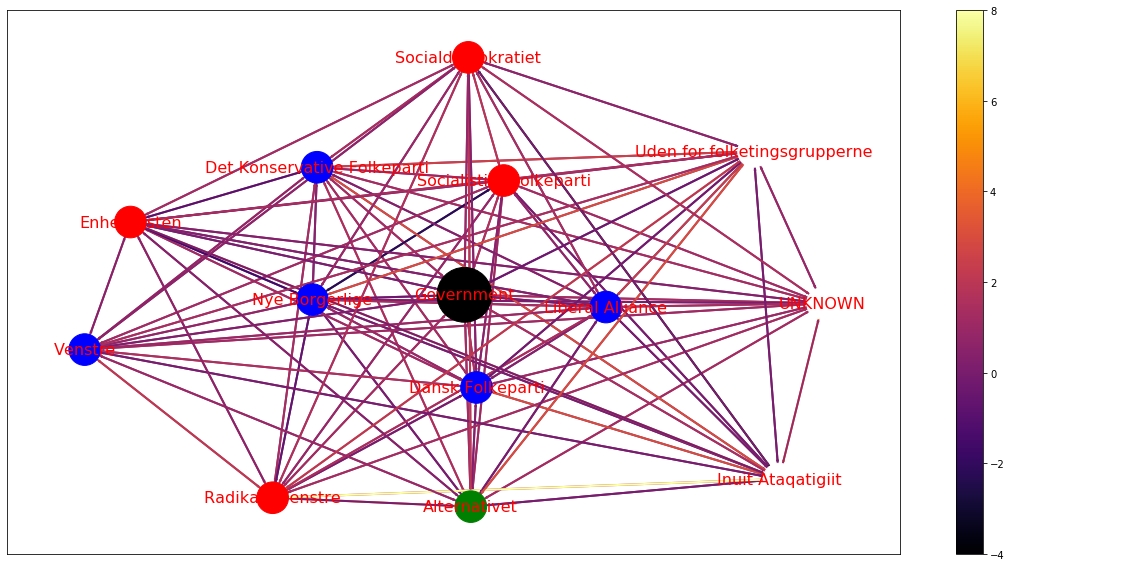

In [89]:
import matplotlib as mpl
G_friends =  G = nx.DiGraph()
# adding edges with weights according to sentiment 
for node in total_sentiment.keys():
    for _node in total_sentiment[node].keys():
        G.add_edge(node, _node)

plt.figure(figsize=(20,10))

pos = forceatlas2.forceatlas2_networkx_layout(G_friends, pos=None, iterations=2000)
M = G.number_of_edges()
print(M)
node_sizes = [1000 for x in range(len(G.nodes))]
node_sizes[5] = 3000
colors_friends = []
#### Plotting a relationship grap
node_color_friends = []
for node in G.nodes():
    if node in blue_bloc:
        node_color_friends.append('blue')
    elif node in red_bloc:
        node_color_friends.append('red')
    elif node in green_bloc:
        node_color_friends.append('green')
    elif node == 'Government':
        node_color_friends.append('black')
    else:
        node_color_friends.append('white')

for key, val in total_sentiment.items():
    for score in val.values():
        colors_friends.append(score['mean']) 
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, with_labels = True, node_color=node_color_friends)
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=2,
    edge_color=colors_friends,
    edge_cmap=plt.cm.inferno,
    width=2,
)
labels = {}    
for node in G.nodes():
    labels[node] = node

nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='r')

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.inferno)
pc.set_array(colors_friends)

plt.colorbar(pc)
ax = plt.gca(label='Score')
ax.set_axis_off()
plt.ylabel('Score')
plt.show()

The node colors have gotten the color of the bloc, where the government gets black and unknown or no party bloc gets white. The graph is a bit too crowded with edges to get a good grasp of what's happening. So let's try something else.

### Sentiment in Tha Danish Parliament

By now it has been shown that the sentiment on Twitter is close to neutral on average yet to the positive side. Is this also the case for the discussions in Parliament where discussions might often be heated and it is not an option to ignore those you disagree with if you want to be reelected? The following analyses is made on the entire data from the Danish Parliament meetings. Later, only those in the Twitter data set are included.

First the sentiment for all speeches are calculated and then party names are joined on the data set.

In [ ]:
#df['Sentiment'] = df['TekstGruppe'].apply(lambda x: afinn_da.score(x))
#df = pd.merge(df, data, left_on='FullName', right_on='Names', how='left')

#df.to_csv("df_sentiment.csv") #For saving the file for later use

In [ ]:
df=pd.read_csv("df_sentiment.csv")
df.head()

Below is a histogram of the sentiments of each speech. It can be seen that 75% of speeches are positive and the rest are either neutral or negative. Given that most speeches start with a few "thank you"s ("Tak" in Danish), a neutral sentiment probably contains a negative message.

In [ ]:
custom_histogram(df['Sentiment'],'Sentiment distribution in the Parliament','Sentiment','Number of speeches')
df['Sentiment'].describe()

The most negative speech with a sentiment of -131 is made by Karina Adsbøl from Dansk Folkeparti regarding violence.

In [ ]:
df[df['Sentiment']==min(df['Sentiment'])]

In [ ]:
print(df[df['Sentiment']==min(df['Sentiment'])]['TekstGruppe'][15290][:490])
print()
print('Sentiment: ',afinn_da.score(df[df['Sentiment']==min(df['Sentiment'])]['TekstGruppe'][15290][:490]))

Notice how she uses the word 'vold', which is Danish for violence, a lot. Each time the sentiment is decremented by 3 as it is considered a very negative word. This snippet of the text has a sentiment of -36 and yet to the reader who understands Danish it leaves the impression of a more or less objective description of violence. This is important to be aware of when essessing the sentiments across people and parties, such that one does not jump to the conclusion that Karina Adsbøl is an angry person who scolds people or objects to everything. It may very well be that the topic of discussion is merely a negative one.

In [ ]:
print('At least',round(len(df[df['Sentiment'] <= 0])/len(df)*100,1),'% of speeches have a negative sentiment.')

In [ ]:
avg_sentiment_party = df.groupby('Party').agg({'Sentiment': (lambda column: stat.mean(column))}).sort_values('Sentiment',ascending=False).reset_index()

fig = plt.subplots(figsize=(10,7))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(avg_sentiment_party['Party'],avg_sentiment_party['Sentiment'])
plt.title("Mean sentiment across parties in Folketinget between late 2017 and now",size=18)
plt.xlabel("Party", size=15)
plt.ylabel("Sentiment", size=15)
plt.show()

Notice that Nye Borgerlige, infamous for being xenofobic, has the lowest average sentiment. So in relation to the above, one should also keep in mind, that one can choose to focus on negative aspects of a topic and another on the positive ones and thereby have different sentiments in the same conversation.

**Conclusion**

Speech in the Danish Parliament is much more formal than it is on Twitter. Therefore, it is no surprise that the average sentiment for both parties. They often start their speech by being appreciative towards the one posing the question as well as the moderator for receiving the word. Also, they often say that they understand the cause of the question or the like, which adds to a positive sentiment score as well. On the other hand, they primarily discuss disagreements on current issues, contributing to the negative side.

The design on the afinn word sentiment analyzer is very simple, in that it only sums the pre defined sentiment for all words in a text and thus does not show if the point regarding a topic with negative sentiment such as violence is actually positive if the word is repeated a lot.

## Analysis step 4:  Parliament & Twitter topics

To compare the topics of the Danish Parliament with Twitter, only the politicians from the Danish Parliament who are also on Twitter will be analyzed going forward. So first, the dataset from the Danish Parliament is joined with the Twitter names in an inner join, to filter out the politicians without Twitter that has not been analyzed in previous sections of this project. This leaves 46,207 speeches equivalent to 64.4% of the previously analyzed data. Unfortunately, this also means that 500 Twitter accounts are not included in this analysis including profiles such as Margrethe Vestager's, since she is not in the Danish Parliament.

In [ ]:
df2=df[df['Twittername'].notnull()]

In [ ]:
print('Removing politicians without Twitter leaves',round(len(df2)/len(df)*100,1),'% of data remaining.')
print('Unfortunately, only ', len(set(df2['Twittername'])), ' out of ',len(set(data['Twittername'])),' politicians are analyzed going forward.')

In [ ]:
df2.groupby('FullName').agg({"TekstGruppe": (lambda x: "".join(x)), 'Sentiment': (lambda x: stat.mean(x))}).sort_values('Sentiment')

Now the text will be processed in the same way as the Twitter text, such that the TF-IDF can be calculated per community. First, the text per person is concatenated, and secondly tokenized. Before creating the word clouds, we check that the most significant words make sense to display in clouds.

In [ ]:
with open('folketinget_dict_concat.data', 'rb') as filehandle:
    # store the data as binary data stream
    folketinget_dict_concat=pickle.load(filehandle)

In [ ]:
list_largest_8_communities = []
for i in range(len(largest_8_communities)):
     list_largest_8_communities.append(largest_8_communities[i][0])

In [ ]:
community_text_folketinget =  dict()
TF_folketinget = dict()
common_pol = dict()
members_community=dict() #What politicians are both in one if the 8 largest Twitter communities and in the Parliament?


for i in range(len(list_largest_8_communities)):
   
    common_pol = [k for k,v in list(partition_GCC_shorterlist.items()) if v == list_largest_8_communities[i]]
    
    members_community[i] = list()
    
    # reset collection of words for each community
    words=[]

    # Tokenize the text in all files in community i and concatenate into one text
    for pol in list(folketinget_dict_concat.keys()):
        if pol in common_pol:
            words += nltk.word_tokenize(folketinget_dict_concat[pol])
            members_community[i].extend([pol])
            
    
    # enter all text from community i in a dict
    tokens = [word.lower() for word in words if (word.isalnum() and word.lower() not in stopwords_edit)]
    
    community_text_folketinget[list_largest_8_communities[i]] = tokens

    
for i in community_text_folketinget.keys():
    TF_folketinget[i] = FreqDist(community_text_folketinget[i])

    
IDF_folketinget = dict()
for community in TF_folketinget.keys():
    IDF_folketinget.update({community: {}})
    for word in TF_folketinget[community].keys():
        IDF_folketinget[community].update({word: IDF_for_word(word, community, TF_folketinget, len(common_communities))})
        

TF_IDF_folketinget = dict()
for community in TF_folketinget.keys():
    TF_IDF_folketinget.update({community: {}})
    for word in TF_folketinget[community].keys():
        TF_IDF_folketinget[community].update({word: TF_folketinget[community][word]*IDF_folketinget[community][word]})

In [ ]:
significant = dict()
for i in TF_IDF_folketinget.keys():
    significant[i] = sorted(TF_IDF_folketinget[i].items(), key=lambda item: item[1], reverse=True)[0:3]

significant

Above is a short list with the three most significant words for each community according to TF-IDF. It is clear that words such as 'Danmark', 'dansk', 'år', and 'forhold' are all considered extremely significant as seven out of eight communities contain at least two of them in the top three. It indicates that Denmark and "Danish'ness" and likely also what is going on this year ("i år"), next year ("næste år") or last year ("sidste år") often is the topic of discussion within Folketinget. 
This is probably a result of the structure of the meetings in the Parliament. Each meeting has an agenda and a moderator so the attendants are guided to discuss certain topics. Also, all of the politicians participate in the same debate in the Parliament.

This is contrary to Twitter, where they can be very concise in expressing concern about a topic that is on their mind immediately and of course also express their own personalities and hobbies.

Below, just the word clouds of community 4 are displayed to show the point above. The left is the word cloud for the text in Christiansborg, and the right is for Twitter, hense the silhouettes.

In [ ]:
christiansborg_mask=np.array(Image.open('christiansborg_sil.jpg'))

In [ ]:
ncols=2

fig, ax = plt.subplots(ncols=ncols, figsize=(50,25))

for col in range(ncols):
    if col == 0:
        community_WordCloudText_chr = ' '.join([word for word in list(TF_IDF_folketinget[common_communities[3]].keys()) for i in range(math.ceil(TF_IDF_folketinget[common_communities[3]][word]))])
        community_wordcloud_chr = WordCloud(collocations=False, mask=christiansborg_mask, background_color='white', stopwords=stopwords_edit).generate(community_WordCloudText_chr)
        ax[col].imshow(community_wordcloud_chr, interpolation='bilinear')
        ax[col].set_title("Community "+str(4)+' Christiansborg', size=50)
        ax[col].axis('off')
            
    if col == 1:
        community_WordCloudText_twi = ' '.join([word for word in list(TF_IDF[common_communities[3]].keys()) for i in range(math.ceil(TF_IDF[common_communities[3]][word]))])
        community_wordcloud_twi = WordCloud(collocations=False, mask=twitter_mask, background_color='white', stopwords=stopwords_edit).generate(community_WordCloudText_twi)
        ax[col].imshow(community_wordcloud_twi, interpolation='bilinear')
        ax[col].set_title("Community "+str(4)+' Twitter', size=50)
        ax[col].axis('off')
        
    
plt.show()

To juke, the nature of the meetings and TF-IDF to force more difference in the word clouds, some of these most significant words are iteratively added to the list of stopwords to filter them out of the word clouds. This could also be done for Twitter to remove mentions of other profiles, but for the sake of the argument, it is only done for Christiansborg as these are more alike. It slightly distorts the true results of the word clouds, but the point of the analysis is to identify the difference between the communities and the similarity between Christiansborg and Twitter.

Below, word clouds are created side by side to compare the topics they are talking about in the Danish Parliament compared to on Twitter.

In [ ]:
stopwords_edit=stopwords_edit.union(['forslaget','statsministeren','ministeren','dansk','danmark','danske',
                                     'forhold','år','regeringen','folketinget','lovforslaget','lovfofslag',
                                    'lovforslag','egentlig','regering','spørgeren','side','sagt','går'])

In [ ]:
nrows=8
ncols=2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(50,250))

for row in range(nrows):
    for col in range(ncols):
        if col == 0:
            community_WordCloudText_chr = ' '.join([word for word in list(TF_IDF_folketinget[common_communities[row]].keys()) for i in range(math.ceil(TF_IDF_folketinget[common_communities[row]][word]))])
            community_wordcloud_chr = WordCloud(collocations=False, mask=christiansborg_mask, background_color='white', stopwords=stopwords_edit).generate(community_WordCloudText_chr)
            axs[row, col].imshow(community_wordcloud_chr, interpolation='bilinear')
            axs[row, col].set_title("Community "+str(common_communities[row])+ ' Christiansborg', size=50)
            axs[row, col].axis('off')

        if col == 1:
            community_WordCloudText_twi = ' '.join([word for word in list(TF_IDF[common_communities[row]].keys()) for i in range(math.ceil(TF_IDF[common_communities[row]][word]))])
            community_wordcloud_twi = WordCloud(collocations=False, mask=twitter_mask, background_color='white', stopwords=stopwords_edit).generate(community_WordCloudText_twi)
            axs[row, col].imshow(community_wordcloud_twi, interpolation='bilinear')
            axs[row, col].set_title("Community "+str(common_communities[row])+' Twitter', size=50)
            axs[row, col].axis('off')

plt.show()

After realizing that the speech in the Danish Parliament and on Twitter might not be well suited for comparison, it is actually interesting to see that there are coincidences between the two forums of expression after all.

So looking at the word clouds above, notice in the word cloud of Christiansborg in community 4 that words such as 'penge' (money), 'arbejde' (work), 'økonomi' (economy), 'kr' (DKK), and 'mia' (billions) are now more outstanding. Recall that this community contains among others Lars Løkke Rasmussen and Kristian Jensen, i.e. prominent figures in the right wing party Venstre which is also mentioned both places. Another similarity to notice is that they address Socialdemokratiet in the Parliament and Mette Frederiksen on Twitter. This shows that the tone is more formal in Christiansborg compared to on Twitter, and even that it is preferred to approach politics from a more personal aspect on in the more exposed media, Twitter. At least in this community.

In [ ]:
members_community[4]

### Parties and wordclouds

In this last subsection, the examination of the following questions will be carried out:
"*Do the parties tweet about the same topics as they talk about at the parliament?*" For answering this, the parties of each of the politicians are used. These informations have already been scrabed, so they are ready to use.  

In [ ]:
#For avoiding running the full explainer, the preprocessed files can be loaded in stead
data=pd.read_csv("danish_politkere_twitter2.csv")

with open('folketinget_dict_concat.data', 'rb') as filehandle:
    folketinget_dict_concat=pickle.load(filehandle)
    
with open('communities.data', 'rb') as filehandle:
    partition_GCC=pickle.load(filehandle)

with open('tweet_concat_v2.data', 'rb') as filehandle:
    dict_concat = pickle.load(filehandle)     

In [ ]:
print("The parties in the danish Parliament: \n")

for party in set(list(data.Party)):
    print(party)


A new dictionary should contain the twitternames and the corresponding political party for each politician. The politicians included is the ones who also are in the GCC.

In [ ]:
party_dict_new=dict()
for i in range(data.shape[0]):
    if data.iloc[i][1] in list(partition_GCC.keys()):
        party_dict_new[data.iloc[i][1]]=data.iloc[i][2]   

#The party of each politicians are also saved in a list
#largest_communities=list(set(party_dict_new.values()))
parties_list=list(set(party_dict_new.values()))

The following code is the same as the in the section [Analysis step 2: Community detection and wordclouds](#Analysis-step-2:-Community-detection-and-wordclouds). Each of the politicians tweets are converted to TF-IDF. Then wordclouds are generated for each party.

In [ ]:
party_text =  dict()
TF = dict()


for i in range(len(parties_list)):

    common_characters = [k for k,v in list(party_dict_new.items()) if v == parties_list[i]]

    # reset collection of words for each community
    words=[]

    # Tokenize the text in all files in community i and concatenate into one text
    for pol in list(dict_concat.keys()):
            if pol in common_characters:
              
                words += nltk.word_tokenize(dict_concat[pol])
    
    # enter all text from community i in a dict
    tokens = [word.lower() for word in words if (word.isalnum() and word.lower() not in stopwords_edit)]
    #words_lemmatized=[lemmatizer.lemmatize("",t)[0] for t in dc_tokens]
    
    party_text[parties_list[i]] = tokens

for i in party_text.keys():
    TF[i] = FreqDist(party_text[i])

In [ ]:
# number of words and text
common_parties=parties_list
for i in range(len(common_parties)):
    print('Party ', common_parties[i],' has ', len(party_text[common_parties[i]]), ' words')

In [ ]:
#inverse document frequency
def IDF_for_word(word, this_com_name, TF_other_community, N):
 
    nt=0
 
    for com in list(TF_other_community.keys()):
        if word in TF_other_community[com] and com != this_com_name:
            nt = nt+1
 
    w_IDF=np.log(N/(nt+1))+1
    return w_IDF

In [ ]:
IDF = dict()

for party in TF.keys():
    IDF.update({party: {}})
    for word in TF[party].keys():
        IDF[party].update({word: IDF_for_word(word, party, TF, len(common_parties))})
        
        
TF_IDF = dict()

for party in TF.keys():
    TF_IDF.update({party: {}})
    for word in TF[party].keys():
        TF_IDF[party].update({word: TF[party][word]*IDF[party][word]})

In [ ]:
significant_twit = dict()
for i in TF_IDF.keys():
    significant_twit[i] = sorted(TF_IDF[i].items(), key=lambda item: item[1], reverse=True)[0:15]

significant_twit

In [ ]:
twitter_mask=np.array(Image.open('twitter_sil.jpg'))

In [ ]:
for party in TF_IDF.keys():
    party_WordCloudText = ' '.join([word for word in list(TF_IDF[party].keys()) for i in range(math.ceil(TF_IDF[party][word]))])

    plt.figure(figsize=(10,20))
    party_wordcloud = WordCloud(collocations=False, mask=twitter_mask, background_color='white', stopwords=stopwords_edit).generate(party_WordCloudText)
    plt.imshow(party_wordcloud, interpolation='bilinear')
    plt.savefig('com_wordclouds/realparties: '+str(community)+'.png')
    plt.title(label=('Party '+str(community)))
    plt.axis("off")

**Conlusion on twitter wordclouds of the parties**
Each of wordclouds now represent the parties in the parliament. Inspecting all of the wordclouds, each party mentions their own parties as one of the main topics. 

E.g. look at the wordcloud for "Venstre", one of the main topics in their tweets are "venstredk" and "venstre" - which is as expected. But the party also mentions "Mette", who is the Prime Minister of Denmark (and unfortunately not on Twitter). They too tweet about "spolitik" which relate to the party of "Mette".

Looking at the wordcloud for "Socialdemokratiet", the main topic is "spolitik", which relates to their own party - again, as expected. They also mentions "venstredk", which relates back to the party "Venstre". What is interesting to see is that the word "børn" is a topic of the cloud. At the newyears speech, Mette said that she stand up for the children in Denmark [link](https://www.socialdemokratiet.dk/da/partiet/vi-er-paa-boernenes-hold/). 

As in the first part of [Analysis step 4: Parliament+twitter topics](#Analysis-step-4:-Parliament+twitter-topics)  this subsection will create wordclouds using the text from the Parliament meetings. The only difference is that now the communities are replaced with the parties.

In [ ]:
party_text_folketinget =  dict()
TF_folketinget = dict()
common_pol = dict()
members_party=dict() #What politicians are both in one if the 8 largest Twitter communities and in the Parliament?


for i in range(len(parties_list)):
   
    common_pol = [k for k,v in list(party_dict_new.items()) if v == parties_list[i]]
    
    members_party[i] = list()
    
    # reset collection of words for each community
    words=[]

    # Tokenize the text in all files in community i and concatenate into one text
    for pol in list(folketinget_dict_concat.keys()):
        if pol in common_pol:
            words += nltk.word_tokenize(folketinget_dict_concat[pol])
            #common_pol['Community '+str(i)] = pol
            members_party[i].extend([pol])
            
    
    # enter all text from community i in a dict
    tokens = [word.lower() for word in words if (word.isalnum() and word.lower() not in stopwords_edit)]
    
    party_text_folketinget[parties_list[i]] = tokens

    
for i in party_text_folketinget.keys():
    TF_folketinget[i] = FreqDist(party_text_folketinget[i])

    
IDF_folketinget = dict()
for party in TF_folketinget.keys():
    IDF_folketinget.update({party: {}})
    for word in TF_folketinget[party].keys():
        IDF_folketinget[party].update({word: IDF_for_word(word, party, TF_folketinget, len(common_parties))})
        

TF_IDF_folketinget = dict()
for party in TF_folketinget.keys():
    TF_IDF_folketinget.update({party: {}})
    for word in TF_folketinget[party].keys():
        TF_IDF_folketinget[party].update({word: TF_folketinget[party][word]*IDF_folketinget[party][word]})

In [ ]:
significant_folk = dict()
for i in TF_IDF_folketinget.keys():
    significant_folk[i] = sorted(TF_IDF_folketinget[i].items(), key=lambda item: item[1], reverse=True)[0:25]

significant_folk

In [ ]:
christiansborg_mask=np.array(Image.open('christiansborg_sil.jpg'))

In [ ]:
nrows=len(common_parties)
ncols=2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(50,250))

for row in range(nrows) : 
    if row!=5:#Not the government
        for col in range(ncols):
            if col == 0:
                party_WordCloudText_chr = ' '.join([word for word in list(TF_IDF_folketinget[common_parties[row]].keys()) for i in range(math.ceil(TF_IDF_folketinget[common_parties[row]][word]))])
                party_wordcloud_chr = WordCloud(collocations=False, mask=christiansborg_mask, background_color='white', stopwords=stopwords_edit).generate(party_WordCloudText_chr)
                axs[row, col].imshow(party_wordcloud_chr, interpolation='bilinear')
                axs[row, col].set_title('Party: '+str(common_parties[row]),size=50)
                axs[row, col].axis('off')
                

            if col == 1:
                party_WordCloudText_twi = ' '.join([word for word in list(TF_IDF[common_parties[row]].keys()) for i in range(math.ceil(TF_IDF[common_parties[row]][word]))])
                party_wordcloud_twi = WordCloud(collocations=False, mask=twitter_mask, background_color='white', stopwords=stopwords_edit).generate(party_WordCloudText_twi)
                axs[row, col].imshow(party_wordcloud_twi, interpolation='bilinear')
                axs[row, col].set_title('Party: '+str(common_parties[row]),size=50)
                axs[row, col].axis('off')
plt.savefig('com_wordclouds/all_realparties_twitter_vs_parliament_v2.png')
plt.show()

**Conlusion on:** "**Do the parties tweet about the same topics as they talk about at the parliament?**"

Now the topics of tweets and topics of the meeting can be compared. This comparison takes the five main topics of meetings and twitter for each party. Notice that we manually de-select all words that are verbs or non-imporant  as adverbs.

Inuit Ataqatigiit
* Meetings: grønland(s), inuit ataqatigiit, grønlandske, arktis, naalakkersuisut, grønlændere, behov, samarbejde
* Twitter: aajacl, greenland, annekatrineb, inuit ataqatigiit, grønland, nuuk, arctic, ilisimatusarfik

Venstre
* Meetings: venstre, arbejde, penge, mennesker, aftale, fald, frem, kr
* Twitter: venstredk, venstre, mette, spolitik, sundpol, jakobelleman, s, dkaid

UNKNOWN
* Meetings: radikale, venstre, sf, eu, grønne, grøn, børn, alternativet
* Twitter: nye, radikale, s, eudk, eu, kommunerne, spolitik, arbejde


Socialdemokratiet
* Meetings:  arbejde, mennesker, børn, mulighed, folk, frem, tid, folkeparti
* Twitter: spolitik, nye, gode, børn, regionerne, randers, venstredk, s

Uden for folketingsgrupperne
* Meetings: alternativet, ansigtsgenkendelsesteknologi, kommuner, arbejde, mulighed, mennesker, offentlige, folkeparti
* Twitter: friegronne, dkgreen, merekisser, sikandisiddique, frihed, uffeelbaek, københavn, regeringdk

Enhedslisten
* Meetings: enhedslisten, mennesker, eu, folk, penge, arbejde, fald, mulighed
* Twitter: enhedslisten, pskipperel, eudk, pelledragsted, pederhvelplund, sundpol, eu, grønne

Nye Borgerlige
* Meetings: nye borgerlige, mennesker, folk, penge, venstre, udlændinge, mulighed, islam
* Twitter: nye borgerlige, dkmedier, klr15, børn, madswibeck, danskerne, eu, udlændinge

Alternativet
* Meetings: alternativet, mennesker, arbejde, folk, penge, fald, udsatte, forsørgerpligt
* Twitter: fannybroholm, franciskarosenk, dkgreen, å, badarshahdk, nikogrunfeld, københavn, josephinefock

Dansk Folkeparti
* Meetings: folkeparti, 
* Twitter: 

Det Konservative Folkeparti
* Meetings: 
* Twitter: 

Socialistisk Folkeparti
* Meetings: 
* Twitter: 

Liberal Alliance
* Meetings: 
* Twitter: 

Radikale Venstre
* Meetings: 
* Twitter: 















# Discussion

### Precision of data 
In terms of the data that is being worked on, there are some things that need to be considered when viewing the analysis. For starters, the dataset is, in a way incomplete as there are still about half of the politicians that are unknown. So when it comes to extracting the most truthful sentiment analysis between parties, the annotation of the rest is important.

Furthermore, there is a lot of difference in the amount of tweets that each politician has, and some politician may use their twitter with more freedom, tweeting about various subjects, whereas others may only use it for political discussion and announcements. This could also add some false information in our data analysis regarding tweet sentiment and topics.

On the other hand, the speech that is extracted from the parliament meetings is all relevant politics, so when we draw comparison between twitter and parliament words and sentiment this could be a bit inaccurate. One thing that could be done to extract more political things on twitter, is to only filter tweets that hashtag things such as #dkpol #eu, and other relevant political hashtags. There's also a difference in the time ranges of tweets and meeting, which will widen the inaccuracies, because it's obvious that humans have changing thoughts and opinions on most subjects, this could also be investigated with matching days of tweets with days of meetings so that when compared, the tweets and meeting data would be in a comparable timeframe. 

### Data analysis
To add to the list of things that could be investigated further, there are some things in the data analysis that could be worked on further. For example, comparing word clouds became a manual and tedious task; methods that could give a score based on similarity should be investigated. Furthermore, it should also be noted that many of the words that were present in the word clouds were  "non-important" words. For example "spørgsmål"(question) should be deemed non important. It is possible to use a list of danish words from, http://fjern-uv.dk/250.pdf to elimnate such words. An other task could also be to lemmatize tweets and speeches, so that it could also benefit the discussion of word clouds and sentiment.

It should be noted that the current prime-minister is unfortunately not included in the database, as she does not have a twitter. It would otherwise have been interesting to see the sentiment scores from politicians to her profile and compare them to the meetings. 

To wrap up this section, it should be understood that the house of cards analysis may, or may not have any real world proof backing it up, as it isn't possible to determine whether or not so

Mette Frederiksen er feks ikke med...


Tidspunkter for tweets vs. tider for meeetings.

Kan politikere skifte holdninger..


Flere tweets?

Forskel på hvor mange tweets folk har

Man kan ikke vide at man påvirker hinanden bare fordi man er connected på twitter


Manuelle del i at selektere "vigtige" emner. Her ville det være oplagt at have brugt a list with danish words: http://fjern-uv.dk/250.pdf. And the process of judging that words like "question" is non-important....


sammenligne wordclouds -> meget kvalitativt... findes dermetoder til at sammenligne?

# Contributions

**Christian:**<p>
Christian has the main responsiblility for the following sections. For these sections, Christian has done all coding + all vizualisations, text regarding methods/theory and conclusions on all of the analyses.
    
Explainer notebook<p>  
    
* Describe datasets: Describe Politicians (parties and regions)
* Data cleaning: Politicians (parties and regions) 
* Preliminary statistics: Adding node-attributes
* Tools, theory and analysis: Analysis step 3: Parties and sentiment

Website <p>
    
* dddd
* ddddd

**Frederik:**<p>
Frederik has the main responsiblility for the following sections. For these sections, Frederik has done all coding + all vizualisations, text regarding methods/theory and conclusions on all of the analyses.
    
Explainer notebook<p> 

* Describe datasets: Describe Political meetings 
* Data cleaning: Political meetings
* Preliminary statistics, Text statistics (twitter and meetings): Meetings text statistics 
* Tools, theory and analysis: "Analysis step 4: Parliament+twitter topics" 


Website <p>
    
* dddd
* ddddd

**Lau:**<p>
Lau has the main responsiblility for the following sections. For these sections, Lau has done all coding + all vizualisations, text regarding methods/theory and conclusions on all of the analyses.

Explainer notebook<p> 

* Describe dataset -> Describe Twitter
* Datacleaning: Twitter Profiles
* Datacleaning: Tweets (who mentions who) 
* Datacleaning: Tweets (only text)
* Preliminary statistics, Text statistics (twitter and meetings): Twitter text statistics (who mentions who)
* Preliminary statistics, Text statistics (twitter and meetings): Twitter text statistics (last 200 tweets for every politician)
* Preliminary statistics: Network statistics (not "adding node-attributes")
* Tools, theory and analysis: "Analysis step 1: Network"
* Tools, theory and analysis: "Analysis step 2: Community detection and wordclouds"

   
Website <p>
    
* Data, Twitterdata
* Network analysis: Preliminary statistics
* Network analysis: Community detection
* Network analysis: House of Cards - the Danish version


   
   
   
   

MANGLER
Discussion



    



# References

Animated GIF Maker. (s.d.). Ezgif.  Retrieved 8.december 2020 at ezgif.com<p>
Barabási, A. . (2015). Communities. In: Network Science. Cambridge University Press. http://networksciencebook.com/chapter/9<p>
Barabási, A. . (2015). Random Networks. In: Network Science. Cambridge University Press. http://networksciencebook.com/chapter/3<p>
Barabási, A. . (2015). The Barabási-Albert Model. In: Network Science. Cambridge University Press. http://networksciencebook.com/chapter/5<p>
Barabási, A. . (2015). The Scale-Free Property. In: Network Science. Cambridge University Press. http://networksciencebook.com/chapter/4<p>
Blokpolitik (s.d.). Wikipedia.  Retrieved 8.december 2020 at https://da.wikipedia.org/wiki/Blokpolitik<p>
Bohn, H.. (s.d.). Trekantområdet. Den Store Danske.  Retrieved 8.december 2020 at https://denstoredanske.lex.dk/Trekantomr%C3%A5det<p>
Brodersen, P.. (s.d.). how to draw communities with networkx. Stackoverflow.  Retrieved 8.december 2020 at https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx<p>
Frederiksen, M.. (s.d.). Vi er på børnenes hold. Socialdemokratiet. Retrieved 9.december 2020 at https://www.socialdemokratiet.dk/da/partiet/vi-er-paa-boernenes-hold/<p>
Folketinget. (s.d.). Folketinget.  Retrieved 8.december 2020 at https://www.ft.dk/<p>
Histogram (s.d.): Sturge's formula. Wikipedia.  Retrieved 8 .december 2020 at https://en.wikipedia.org/wiki/Histogram#Sturges'_formula<p>
House of Cards (American TV series). Wikipedia.  Retrieved 8.december 2020 at https://en.wikipedia.org/wiki/House_of_Cards_(American_TV_series)<p>
Inc, Twitter. (s.d.). Developers. Developer Twitter.  Retrieved 8.december 2020 at https://developer.twitter.com/en<p>
Inc, Twitter. (s.d.). Help Center. Twitter.  Retrieved 8.december 2020 at help.twitter.com/en<p>
Kend dit regionsråd. (s.d.). Region Midtjylland.  Retrieved 8.december 2020 at https://www.rm.dk/politik/regionsradsmedlemmer/<p>
Medlemmer af regionsrådet 2018-2021. (s.d.). Region Hovedstaden.  Retrieved 8.december 2020 at https://www.regionh.dk/politik/politiske-udvalg-og-fora/regionsraadet/Sider/Medlemmer_af_regionsraadet_2018-2021.aspx<p>
Nordjylland, Region. (s.d.). Regioner i Danmark. Region Nordjylland.  Retrieved 8.december 2020 at https://rn.dk/genveje/fakta-om-nordjylland/regioner-i-danmark<p>
Politikere, Danske. (s.d.). Alle danske politikere i databasen: Oversigt over danske politikere. Danske Politikere.  Retrieved 8.december 2020 at https://www.danskepolitikere.dk/oversigt/danske-politikere<p>
Poulsen, E. . & Wallberg, F. . (s.d.). Twitterpolitikere.dk. Twitterpolitikere. Retrieved  8.december 2020 at https://filip.journet.sdu.dk/twitter/politikere/<p>
Regionsrådets medlemmer. (s.d.). Region Sjælland.  Retrieved 8.december 2020 at https://www.regionsjaelland.dk/politik/regionsraadet/regionsraadets-medlemmer/Sider/default.aspx<p>
Regionsrådets medlemmer. (s.d.). Region Syddanmark.  Retrieved 8.december 2020 at https://www.regionsyddanmark.dk/wm436558<p>
Starcke-Jensen, L.. (s.d.). Opdag Danmark. Opdag Danmark.  Retrieved 8.december 2020 at https://www.opdagdanmark.dk/<p>
Trekantområdet. (s.d.). DR.  Retrieved 8.december 2020 at https://www.dr.dk/nyheder/regionale/trekanten<p>
Trekantområdet. (s.d.). Trekantområdet.  Retrieved 8.december 2020 at https://da.wikipedia.org/wiki/Trekantomr%C3%A5det<p>

# Appendix
## Data scraping of parties

Note that these blocs have already been ran, so the variable `data` used above is generated from this 

### Regions - Nordjylland

In [ ]:
nordjylland_url = "https://rn.dk/da/Politik/De-regionale-politikere"

soup = BeautifulSoup(requests.get(nordjylland_url).content, 'html.parser')

In [ ]:
match_rnj = []
pre_re = r"\b[A-Z].*"
div_lsit = soup.findAll("ul", {'class': 'span3'})
for paragraph in div_lsit:
    text= paragraph.text
    text_stripped = text.rstrip().lstrip()
    #print(text_stripped)
    matches_1 = re.findall(pre_re, text_stripped)
    #print(matches_1)
    match_rnj.append(matches_1)

# 0 and even indices are names, 1 and odd are the matching parti strings

In [ ]:
# note that relevant matches come at last 2 indices
good_match = match_rnj[len(match_rnj)-2] + match_rnj[len(match_rnj)-1]

# remove strings that contain "formand" as it's not relevant information
good_match = [x for x in good_match if "formand" not in x.lower() if "\r" not in x.lower()]

for i in range(len(good_match)-1):
    name = good_match[i].lower()
    party_string = good_match[i+1]
    if name in data['Names']:
        data.loc[data['Names'] == name, 'Party'] = party_string.replace("Parti: ", "")
        data.loc[data['Names'] == name, 'Region'] = 'nordjylland'


### Regions - Midtjylland

In [ ]:
url = 'https://www.rm.dk/politik/regionsradsmedlemmer/'

req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')

content = soup.find("div", {"class": "text-content"})

unwanted = content.findAll("p")
for u in unwanted:
    u.clear()

# removing some introductioniary text
unwanted = content.find("h2")
unwanted.clear()
unwanted.find_next().clear()
clean_content = content.text.rstrip()

# removing unwanted brackets ()
pattern = r"\(.*?\)"
clean_content = re.sub(pattern, '', clean_content)


#print(clean_content) # left with this string

all_parties = content.findAll("h3")
for party in all_parties:
    #print(party.text)
    party_text = re.sub(pattern,'', party.text)
    people = party.find_next('ul')
    people_text = re.sub(pattern, "", people.text)
    for name in people_text.split('\n'):
        if name in data.values:
            #print(name + "  in   " + party_text)
            data.loc[data['Names'] == name, 'Party'] = party_text.rstrip()
            data.loc[data['Names'] == name, 'Region'] = 'midtjylland'
            
            

### Region - Syddammark

In [ ]:
url = 'https://www.regionsyddanmark.dk/wm436558'
req = requests.get(url)

soup = BeautifulSoup(req.content, 'html.parser')
content = soup.find("div", {"class": "brodtekst"})

unwanted = content.findAll("p")
for u in unwanted:
    u.clear()

    
all_parties = content.findAll("h3")
i = 0
for party in all_parties:
        party_text = re.sub(pattern,'', party.text)
        people = party.find_next('ul')
        people_text = re.sub(pattern, "", people.text)
        for people in people_text.split('\n'):
            if people.strip() in data.values:
                print(people.strip() + "  in   " + party_text.strip())
                data.loc[data['Names'] == people.strip(), 'Party'] = party_text.strip()
                data.loc[data['Names'] == name, 'Region'] = 'syddanmark'    

### Region - Sjælland

In [ ]:
url = 'https://www.regionsjaelland.dk/politik/regionsraadet/regionsraadets-medlemmer/Sider/default.aspx'
req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')

content = soup.findAll('div',{'class': 'employeList'})
content = content[1:]
for name_content in content:
    name = name_content.a['title']
    spans = name_content.findAll('span')
    party = spans[1]

    party_text = party.text.split(',')[1]
    party_text = re.sub(pattern, '', party_text)
    if name.strip() in data.values:
        #print(name.strip() + "  in   " + party_text.strip())
        data.loc[data['Names'] == name.strip(), 'Party'] = party_text.strip()
        data.loc[data['Names'] == name, 'Region'] = 'sjælland'


### Region - Hovedstaden

In [ ]:
url = 'https://www.regionh.dk/politik/politiske-udvalg-og-fora/regionsraadet/Sider/Medlemmer_af_regionsraadet_2018-2021.aspx'

req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')
content = soup.findAll('h2', {'class': 'rh-Element-H2A'})

for party in content:
    #print(party.text)
    party_text = re.sub(pattern, '', party.text)
    #print(party_text.strip())
    #print("")
    names = party.find_all_next('h3', {'rh-Element-H3A'})
    # bit weird website structure compared to others so differnet method is used
    # each party returns the names of politicians + those listed after it
    # we can update each name setting it to the party continously for each element
    for name in names:
        name_text = name.text
        name_text = name_text.strip()
        #print(name_text)
        if name_text in data.values:
                #print(name_text + " in " + party_text.strip())
                data.loc[data['Names'] == name_text, 'Party'] = party_text.strip()
                data.loc[data['Names'] == name, 'Region'] = 'hovedstaden'


## From folketinget.dk

In [ ]:
### nordjyllands storkreds
def getFromFt(url: str, region: str):
    req=requests.get(url)
    soup = BeautifulSoup(req.content, 'html.parser')
    memberInfos = soup.findAll('tr')
    # skip table header
    memberInfos = memberInfos[1:]
    #print("Found " + str(len(memberInfos)))
    for member in memberInfos:
        # format: '\n\n -> first_name -> last_name -> party
        dataList = [x.text for x in member.findAll('td')]
        try:
            _, firstName, lastName, party, _, _ = dataList
            name = firstName + " " + lastName
            if name in data.values:
                #print("In twitter csv: " + name + " " + party)
                #print("Old party: " + data.loc[data['Names']==name]['Party'])
                data.loc[data['Names'] == name, 'Party'] = party
                data.loc[data['Names'] == name, 'Region'] = region

        except:
            print("failed for")
            print(dataList)



url = 'https://www.ft.dk/searchResults.aspx?sortedDescending=false&consti=%7bD68D9A59-8A4B-426D-AD9C-9B32FE3CE071%7d&page=1&sortedBy=&pageSize=200'
getFromFt(url, 'nordjylland')
data.groupby('Party').count()

In [ ]:
## Vestjyllandsstokkreds + øst
# trying same code

url = 'https://www.ft.dk/searchResults.aspx?sortedDescending=false&consti={97A50F7E-B9D0-4D91-924F-AB20235DB4FD}'
getFromFt(url, 'midtjylland')
#data.groupby('Party').count()

# østjylland
url = 'https://www.ft.dk/searchResults.aspx?sortedDescending=false&consti={E3910753-B21F-4E97-AD2B-67A9A3C15B62}'
getFromFt(url, 'midtjylland')
data.groupby('Party').count()

In [ ]:
# syddanmark
url = 'https://www.ft.dk/searchResults.aspx?sortedDescending=false&consti={7D7567F4-3425-42A1-A035-2FB9880A5F81}'
getFromFt(url, 'syddanmark')
data.groupby('Party').count()


url ='https://www.ft.dk/searchResults.aspx?sortedDescending=false&consti={B3A26626-55E1-4BE2-8503-E4027904E25A}'
getFromFt(url, 'syddanmark')
data.groupby('Party').count()

In [ ]:
url = 'https://www.ft.dk/searchResults.aspx?sortedDescending=false&consti=%7b79B9CCF4-4793-4835-8E68-6770AA11A85D%7d&page=1&sortedBy=&pageSize=50'
getFromFt(url, 'sjælland')
data.groupby('Party').count()

In [ ]:
# Region hovedstadan
url1 = 'https://www.ft.dk/searchResults.aspx?sortedDescending=false&consti={4C1C732F-4F3C-408E-A009-C96E6934B29C}'
url2 = 'https://www.ft.dk/searchResults.aspx?sortedDescending=false&consti={3F642D1B-1820-48F1-A288-AA1FE9079640}'
url3 = 'https://www.ft.dk/searchResults.aspx?sortedDescending=false&consti={6A4F6A85-C5C1-4656-BD9A-7831094A5A81}'
url4 = 'https://www.ft.dk/searchResults.aspx?sortedDescending=false&consti={E76B8CF6-E8A7-4B29-9813-350C49E36238}'

getFromFt(url1, 'hovedstadan')
getFromFt(url2, 'hovedstadan')
getFromFt(url3, 'hovedstadan')
getFromFt(url4, 'hovedstadan')

data.groupby('Party').count()

### Analyzing why there are still so many unknowns
Looks like there are several reasons, some names have emojis. Some have misplaced whitespaces, sometimes more
sometimes 0. There are some names in the list that are entities and not people - such as AMPJ or various ministeries.
There can also be trouble finding politicians because of the capitalization (easy fix) and laslty,
some middle names are abbreviated and some aren't; making it harder to know and find the specific politician.


### Duplicates removal

In [ ]:
#SF - Socialistisk Folkeparti = Socialistisk Folkeparti
# Venstre = Venstre, Danmarks Liberale Parti
# Socialdemokratiet = Socialdemokraterne
data=pd.read_csv("danish_politkere_twitter2.csv")
party_replacements = {
        'Venstre, Danmarks Liberale Parti': 'Venstre',
        'Socialdemokraterne': 'Socialdemokratiet',
        'SF - Socialistisk Folkeparti': 'Socialistisk Folkeparti',
        'Enhedslisten - De Rød-Grønne': 'Enhedslisten',
        'Løsgænger': 'Uden for folketingsgrupperne',
        'Frie Grønne, Danmarks Nye Venstrefløjsparti': 'Uden for folketingsgrupperne',
        'Det Radikale Venstre': "Radikale Venstre"
}

to_replace = ["Det Radikale Venstre", 'Venstre, Danmarks Liberale Parti', 'Socialdemokraterne', 'SF - Socialistisk Folkeparti','SF - Socialistisk Folkeparti','Enhedslisten - De Rød-Grønne', 'Løsgænger', 'Frie Grønne, Danmarks Nye Venstrefløjsparti']

data["Party"] = data.apply(lambda x: party_replacements[x["Party"]] if x["Party"] in to_replace else x["Party"], axis=1)

data.groupby('Party').count()

Marking certain Twitter profiles that were unknown as GOVERNMENT

In [ ]:
unknowns = data.loc[data['Party'] == "UNKNOWN"]
party = 'Government'
region = 'government'
for x in unknowns.iterrows():
    politician = x[1][0]
    if re.match(r'.+ministeriet', politician):
        if politician in data.values:
            print("In twitter csv: " + politician)
            print("Old party: " + data.loc[data['Names']==politician]['Party'])
            data.loc[data['Names'] == politician, 'Party'] = party
            data.loc[data['Names'] == politician, 'Region'] = region


In [ ]:
#Some special cases 
data.loc[data['Names'] == "Regeringen", 'Party'] = 'Government'
data.loc[data['Names'] == "Regeringen", 'Region'] = 'Government'

print(data.loc[data['Names']=="Regeringen"]['Party'])

data.groupby('Party').count()

In [ ]:
# write to csv
data.to_csv('danish_politkere_twitter2.csv',index= False)

In [ ]:
#If degree weight should in the light of these results in fact also depend on the in_degree. One could assume that 

#Maybe the weights should be normalized by the number of edges conneting to the node